In [9]:
import sys
sys.path.append(r'/hr-fs02/hr_projekte/Pol-InSAR_InfoRetrieval/10_users/mans_is/PyPolSAR')


import rioxarray
import rasterio as rio
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import box, mapping
from scipy import ndimage
from pypolsar import geo
import pprint



import h5py

from pypolsar import polsar
import matplotlib.pyplot as plt

from pypolsar import utils, plot
from pypolsar import polsar
from pypolsar.polsar import decomposition

from pypolsar.stats.timer import Timer
from pathlib import Path
import pypolsar

import seaborn as sns
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap


fig_save = Path("./../figures/")

from pathlib import Path


In [10]:
def plot_2dhist_sns_range_profile(df, col='UnitName', hue="band", x_hist='aoi', 
                    y_hist='entropy', suptitle=None, x_y_label_dict=None, 
                    xlim=None, ylim=None):
    sns.set(font_scale=1.85)  # crazy big
    sns.set_style("white")

    g = sns.FacetGrid(df, col=col, height=6, aspect=1, 
                      hue="band", palette=sns.color_palette("tab10",2), 
                      xlim=xlim, ylim=ylim)
    g.map(sns.histplot, x_hist, y_hist, bins=300, )
    if x_y_label_dict is not None :
        g.set_axis_labels(x_y_label_dict[x_hist], x_y_label_dict[y_hist])
        
    legend_name  = ['L-Band', 'S-Band',]
    LegendElement = {}
    LegendElement[legend_name[0]] = mpatches.Patch(color=sns.color_palette("tab10",2)[0], label=legend_name[0])
    LegendElement[legend_name[1]] = mpatches.Patch(color=sns.color_palette("tab10",2)[1], label=legend_name[1])

    legend_items = []

    [legend_items.append(x) for x in list(dict(sorted(LegendElement.items())).values())]



    g.add_legend(title="Band", handles=legend_items )
    if suptitle is not None:
        g.fig.subplots_adjust(top=0.85)
        g.fig.suptitle(suptitle,
                      fontsize=24, fontdict={"weight": "bold"})
    return g

In [22]:

def combine_netcdf(path_18, path_19, clip=None):
    ds_1 = xr.open_dataset(path_18)
    ds_2 = xr.open_dataset(path_19)

    ds_con = xr.concat([ds_1, ds_2], dim=pd.Index([2018, 2019], name='time'))
    ds_con = ds_con.where(ds_con.mask_valid == 1) 
    if clip is not None:
        ds_con = clip_raster_with_shp(ds_con, shapefile= shapefile_clip)
    
    return ds_con


def create_mean_along_dim(main_df, mean_by='aoi', n_bins=1000):
    main_df_mean = (main_df
      .assign(Bin=lambda x: pd.cut(x[mean_by], bins=n_bins))
      .groupby(['Bin'])
      .agg(['mean', 'count'])
     )
    
    return main_df_mean


def create_mean_df(df_masked_mean, UnitName, Band):
    offnadir_mean = df_masked_mean['offnadir']['mean'].values
    aoi_mean = df_masked_mean['aoi']['mean'].values
    entropy_mean = df_masked_mean['entropy']['mean'].values
    alpha_mean = df_masked_mean['alpha']['mean'].values
    p_hhvv_mean = df_masked_mean['p_hhvv']['mean'].values
    ph_diff_hhvv_mean = df_masked_mean['ph_diff_hhvv']['mean'].values
    anisotropy_mean = df_masked_mean['anisotropy']['mean'].values
    df_tmp = pd.DataFrame(
        [(UnitName, aoi_mean, offnadir_mean, entropy_mean, alpha_mean, p_hhvv_mean, anisotropy_mean, ph_diff_hhvv_mean, Band)],
        columns=["UnitName", 'aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv', 'band'])
    df_tmp = df_tmp.apply(pd.Series.explode).reset_index()
    return df_tmp.dropna()
    

def create_mean_dataframes(path_L_18, path_L_19, path_S_18, path_S_19):
    ds_l = combine_netcdf(path_L_18 , path_L_19)
    ds_s = combine_netcdf(path_S_18, path_S_19)
    ds_l["offnadir"] = np.rad2deg(ds_l["offnadir"])
    ds_s["offnadir"] = np.rad2deg(ds_s["offnadir"])
    ds_l["aoi"] = np.rad2deg(ds_l["aoi"])
    ds_s["aoi"] = np.rad2deg(ds_s["aoi"])


    unit_masks = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove_+Jae', 'Thrasher']
    unit_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']
    df_18_mean = pd.DataFrame([], columns=["UnitName", 'aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv', 'band'])
    df_19_mean = pd.DataFrame([], columns=["UnitName", 'aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv', 'band'])

    for UnitName, UnitMask in zip(unit_names, unit_masks):
        print(UnitName)
        ## mask and create dataframe L- Band
        df_L = ds_l.where(ds_l['mask_'+UnitMask] == 1).to_dataframe().dropna()
        df_S = ds_s.where(ds_s['mask_'+UnitMask] == 1).to_dataframe().dropna()

        ################
        df_masked_L_2018 = df_L.iloc[df_L.index.get_level_values('time') == 2018]
        df_masked_L_2019 = df_L.iloc[df_L.index.get_level_values('time') == 2019]
        df_masked_S_2018 = df_S.iloc[df_S.index.get_level_values('time') == 2018]
        df_masked_S_2019 = df_S.iloc[df_S.index.get_level_values('time') == 2019]

        #########
        df_masked_L_mean_2018 = create_mean_along_dim(main_df=df_masked_L_2018, mean_by='aoi', n_bins=10000)
        df_masked_L_mean_2019 = create_mean_along_dim(main_df=df_masked_L_2019, mean_by='aoi', n_bins=10000)
        df_masked_S_mean_2018 = create_mean_along_dim(main_df=df_masked_S_2018, mean_by='aoi', n_bins=10000)
        df_masked_S_mean_2019 = create_mean_along_dim(main_df=df_masked_S_2019, mean_by='aoi', n_bins=10000)

        ################
        df_mean_L_2018 = create_mean_df(df_masked_L_mean_2018, UnitName, Band='L')
        df_mean_L_2019 = create_mean_df(df_masked_L_mean_2019, UnitName, Band='L')
        df_mean_S_2018 = create_mean_df(df_masked_S_mean_2018, UnitName, Band='S')
        df_mean_S_2019 = create_mean_df(df_masked_S_mean_2019, UnitName, Band='S')


        ################
        df_18_mean = df_18_mean.append(df_mean_L_2018)
        df_18_mean = df_18_mean.append(df_mean_S_2018)
        
        df_19_mean = df_19_mean.append(df_mean_L_2019)
        df_19_mean = df_19_mean.append(df_mean_S_2019)
        
    return df_18_mean, df_19_mean

In [26]:
def process(band="L" , band1="S", ID_Pass=0, x_hist='aoi'):
    
    process_path = Path('./../data/processed/')
    # p = Path('./')
    prmasr_nc = {}
    prmasr_nc["L"] = {}
    prmasr_nc["S"] = {}
    prmasr_nc["L"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*L.nc')))
    prmasr_nc["L"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*L.nc')))
    prmasr_nc["S"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*S.nc')))
    prmasr_nc["S"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*S.nc')))
    prmasr_nc
    print('#############')
    print(band, ID_Pass,)
    print('#############')

    
    print(prmasr_nc[band]["18"][int(ID_Pass)], prmasr_nc[band]["19"][int(ID_Pass)])
    print(prmasr_nc[band1]["18"][int(ID_Pass)], prmasr_nc[band1]["19"][int(ID_Pass)])
    print('#############')
    
    dfmean_18, df_mean19 = create_mean_dataframes(
        path_L_18=prmasr_nc[band]["18"][ID_Pass], path_L_19= prmasr_nc[band]["19"][ID_Pass], 
        path_S_18=prmasr_nc[band1]["18"][ID_Pass], path_S_19=prmasr_nc[band1]["19"][ID_Pass])
    

    latex_label = {'entropy': 'Entropy (${H}_w$)', 
               'offnadir': 'offnadir [deg]',
               'anisotropy': 'Anisotropy (${H}_w$)', 
               'alpha': 'Alpha (${\\alpha}_{avg}$) [deg]',
               'p_hhvv': '${P}_{HHVV}$',
               'ph_diff_hhvv': 'CPD ${Phase}_{HHVV}$ [deg]',
               'aoi': 'AOI [deg]',}


    pol_key = ['entropy', 'anisotropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv', 'aoi', 'offnadir']
    pol_key

    x_hist= x_hist


    for item in pol_key:
        print(item)
        if x_hist != item:
            file_name = prmasr_nc[band]["18"][ID_Pass].name[:-3] + " " + prmasr_nc[band1]["18"][ID_Pass].name[:-3]
            pol_key_name = item
            if pol_key_name == "p_hhvv":
                ylim=(0.5, 1.5)
            elif pol_key_name == "ph_diff_hhvv":
                ylim=(-20, 40)
            else:
                ylim=None

            print('Save Figure', file_name)
            
            ### Section 2018
            fig = plot_2dhist_sns_range_profile(df=dfmean_18, 
                             x_hist=x_hist, y_hist=pol_key_name, ylim=ylim, suptitle=file_name,
                            col='UnitName', hue='band', x_y_label_dict=latex_label)


            fig.savefig(fig_save.joinpath('PNG', "range_profile", file_name + "_" +
                                          x_hist + '-' +  pol_key_name + ".png"))
            # plt.clf()
            
            
            ### Section 2019
            file_name = prmasr_nc[band]["19"][ID_Pass].name[:-3] + " " + prmasr_nc[band1]["19"][ID_Pass].name[:-3]

            print('Save Figure', file_name)
            
            fig = plot_2dhist_sns_range_profile(df=dfmean_18, 
                             x_hist=x_hist, y_hist=pol_key_name, ylim=ylim, suptitle=file_name,
                            col='UnitName', hue='band', x_y_label_dict=latex_label)


            fig.savefig(fig_save.joinpath('PNG', "range_profile", file_name + "_" +
                                          x_hist + '-' +  pol_key_name + ".png"))
            # plt.clf()
            
            

In [33]:
def create_diff_dataframe_from_xarray(ds_time):
    
    diff_entropy = ds_time.isel(time=[0])['entropy'].data - ds_time.isel(time=[1])['entropy'].data
    diff_anisotropy = ds_time.isel(time=[0])['anisotropy'].data - ds_time.isel(time=[1])['anisotropy'].data
    diff_alpha = ds_time.isel(time=[0])['alpha'].data - ds_time.isel(time=[1])['alpha'].data
    diff_p_hhvv = ds_time.isel(time=[0])['p_hhvv'].data - ds_time.isel(time=[1])['p_hhvv'].data
    diff_ph_diff_hhvv = ds_time.isel(time=[0])['ph_diff_hhvv'].data - ds_time.isel(time=[1])['ph_diff_hhvv'].data

    diff_aoi = ds_time.isel(time=[0])['aoi'].data
    diff_offnadir = ds_time.isel(time=[0])['offnadir'].data


    df_masked_diff = pd.DataFrame([], 
                                columns=['aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv']).dropna()
    df_masked_diff['aoi'] = diff_aoi.flatten()
    df_masked_diff['offnadir'] = diff_offnadir.flatten()
    df_masked_diff['entropy'] = diff_entropy.flatten()
    df_masked_diff['alpha'] = diff_alpha.flatten()
    df_masked_diff['p_hhvv'] = diff_p_hhvv.flatten()
    df_masked_diff['anisotropy'] = diff_anisotropy.flatten()
    df_masked_diff['ph_diff_hhvv'] = diff_ph_diff_hhvv.flatten()
    
    return df_masked_diff.dropna()
    

def create_mean_diff_dataframes(path_L_18, path_L_19, path_S_18, path_S_19):
    ds_l = combine_netcdf(path_L_18 , path_L_19)
    ds_s = combine_netcdf(path_S_18, path_S_19)
    ds_l["offnadir"] = np.rad2deg(ds_l["offnadir"])
    ds_s["offnadir"] = np.rad2deg(ds_s["offnadir"])
    ds_l["aoi"] = np.rad2deg(ds_l["aoi"])
    ds_s["aoi"] = np.rad2deg(ds_s["aoi"])


    unit_masks = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove_+Jae', 'Thrasher']
    unit_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']
    df_18_19_diff_mean = pd.DataFrame([], columns=["UnitName", 'aoi', "offnadir", "entropy", "alpha", 'p_hhvv', 'anisotropy', 'ph_diff_hhvv', 'band'])

    for UnitName, UnitMask in zip(unit_names, unit_masks):
        print(UnitName)
        ## mask and create dataframe L- Band
        
        df_masked_L = create_diff_dataframe_from_xarray(ds_l.where(ds_l['mask_'+UnitMask] == 1))
        df_masked_S = create_diff_dataframe_from_xarray(ds_s.where(ds_s['mask_'+UnitMask] == 1))


        #########
        df_masked_L_mean = create_mean_along_dim(main_df=df_masked_L, mean_by='aoi', n_bins=10000)
        df_masked_S_mean = create_mean_along_dim(main_df=df_masked_S, mean_by='aoi', n_bins=10000)

        ################
        df_mean_L = create_mean_df(df_masked_L_mean, UnitName, Band='L')
        df_mean_S = create_mean_df(df_masked_S_mean, UnitName, Band='S')


        ################
        df_18_19_diff_mean = df_18_19_diff_mean.append(df_mean_L)
        df_18_19_diff_mean = df_18_19_diff_mean.append(df_mean_S)
        

        
    return df_18_19_diff_mean

In [36]:
def process_diff(band="L" , band1="S", ID_Pass=0, x_hist='aoi'):
    
    process_path = Path('./../data/processed/')
    # p = Path('./')
    prmasr_nc = {}
    prmasr_nc["L"] = {}
    prmasr_nc["S"] = {}
    prmasr_nc["L"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*L.nc')))
    prmasr_nc["L"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*L.nc')))
    prmasr_nc["S"]["18"] = sorted(list( process_path.glob('./ecological_masks/18*S.nc')))
    prmasr_nc["S"]["19"] = sorted(list( process_path.glob('./ecological_masks/19*S.nc')))
    prmasr_nc
    print('#############')
    print(band, ID_Pass,)
    print('#############')

    
    print(prmasr_nc[band]["18"][int(ID_Pass)], prmasr_nc[band]["19"][int(ID_Pass)])
    print(prmasr_nc[band1]["18"][int(ID_Pass)], prmasr_nc[band1]["19"][int(ID_Pass)])
    print('#############')
    
    df_18_19_diff_mean= create_mean_diff_dataframes(
        path_L_18=prmasr_nc[band]["18"][ID_Pass], path_L_19= prmasr_nc[band]["19"][ID_Pass], 
        path_S_18=prmasr_nc[band1]["18"][ID_Pass], path_S_19=prmasr_nc[band1]["19"][ID_Pass])
    


    latex_label = {'entropy': 'Entropy (${H}_w$)', 
               'offnadir': 'offnadir [deg]',
               'anisotropy': 'Anisotropy (${H}_w$)', 
               'alpha': 'Alpha (${\\alpha}_{avg}$) [deg]',
               'p_hhvv': '${P}_{HHVV}$',
               'ph_diff_hhvv': 'CPD ${Phase}_{HHVV}$ [deg]',
               'aoi': 'AOI [deg]',}


    pol_key = ['entropy', 'anisotropy', 'alpha', 'p_hhvv', 'ph_diff_hhvv', 'aoi', 'offnadir']
    pol_key

    x_hist= x_hist


    for item in pol_key:
        print(item)
        if x_hist != item:
            file_name = prmasr_nc[band]["18"][ID_Pass].name[:-3] + " " + prmasr_nc[band1]["18"][ID_Pass].name[:-3]
            pol_key_name = item
            if pol_key_name == "p_hhvv":
                ylim=(-1, 1)
            elif pol_key_name == "ph_diff_hhvv":
                ylim=(-20, 40)
            elif pol_key_name == "entropy" or pol_key_name == "anisotropy" :
                ylim=[-0.5, 1]
            elif pol_key_name == "alpha":
                ylim=None
            else:
                ylim=None

            print('Save Figure', file_name)
            
            ### Section 2018
            fig = plot_2dhist_sns_range_profile(df=df_18_19_diff_mean, 
                             x_hist=x_hist, y_hist=pol_key_name, ylim=ylim, suptitle=file_name,
                            col='UnitName', hue='band', x_y_label_dict=latex_label)


            fig.savefig(fig_save.joinpath('PNG', "range_profile", "diff_" + file_name + "_" +
                                          x_hist + '-' +  pol_key_name + ".png"))

            
            

#############
L 0
#############
../data/processed/ecological_masks/18prmasr0302_L.nc ../data/processed/ecological_masks/19prmasr1002_L.nc
../data/processed/ecological_masks/18prmasr0302_S.nc ../data/processed/ecological_masks/19prmasr1002_S.nc
#############
Avadlek
Guillemot
Herschel
Komakuk
Orca
Plove+Jae
Thrasher
entropy
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


anisotropy
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


alpha
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


p_hhvv
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


ph_diff_hhvv
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


aoi
offnadir
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


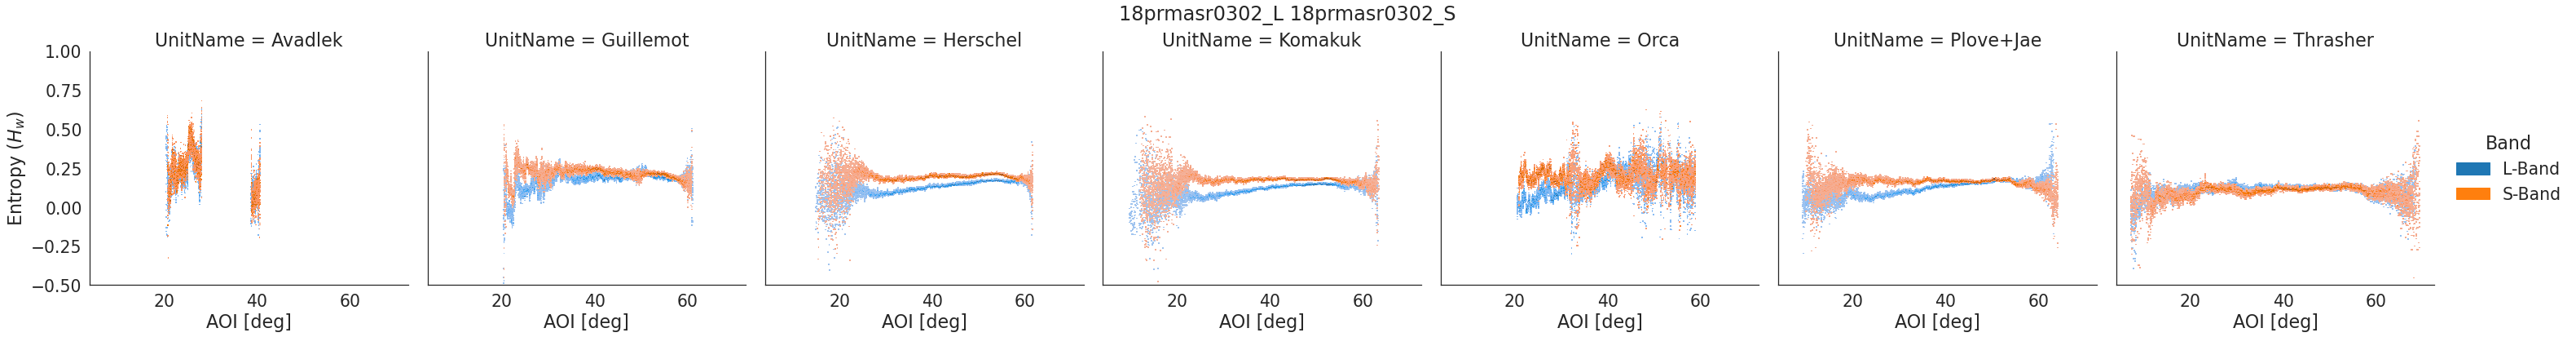

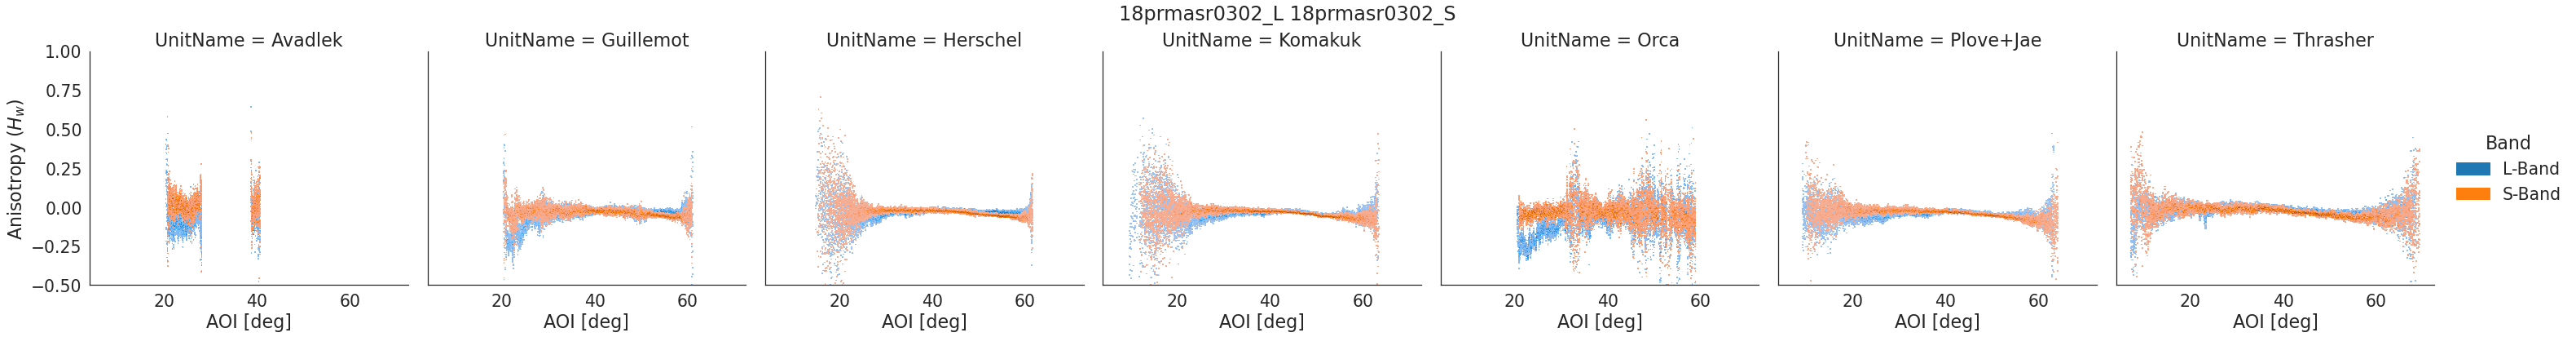

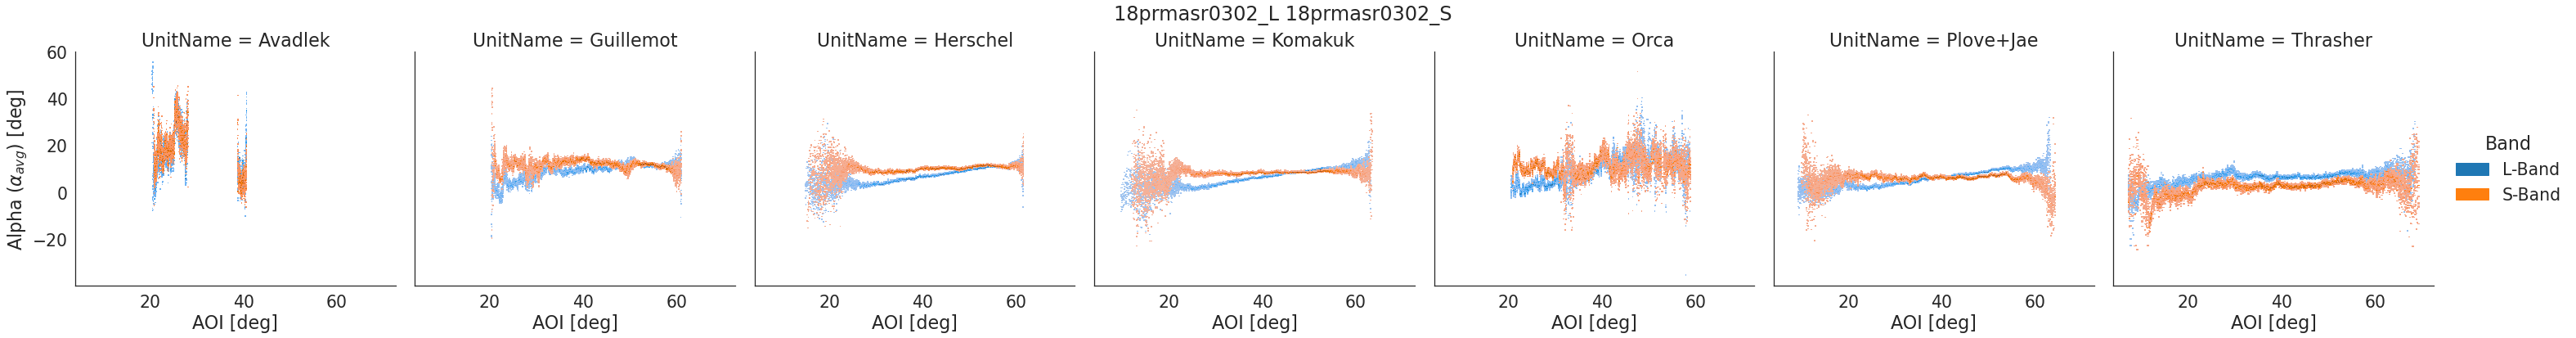

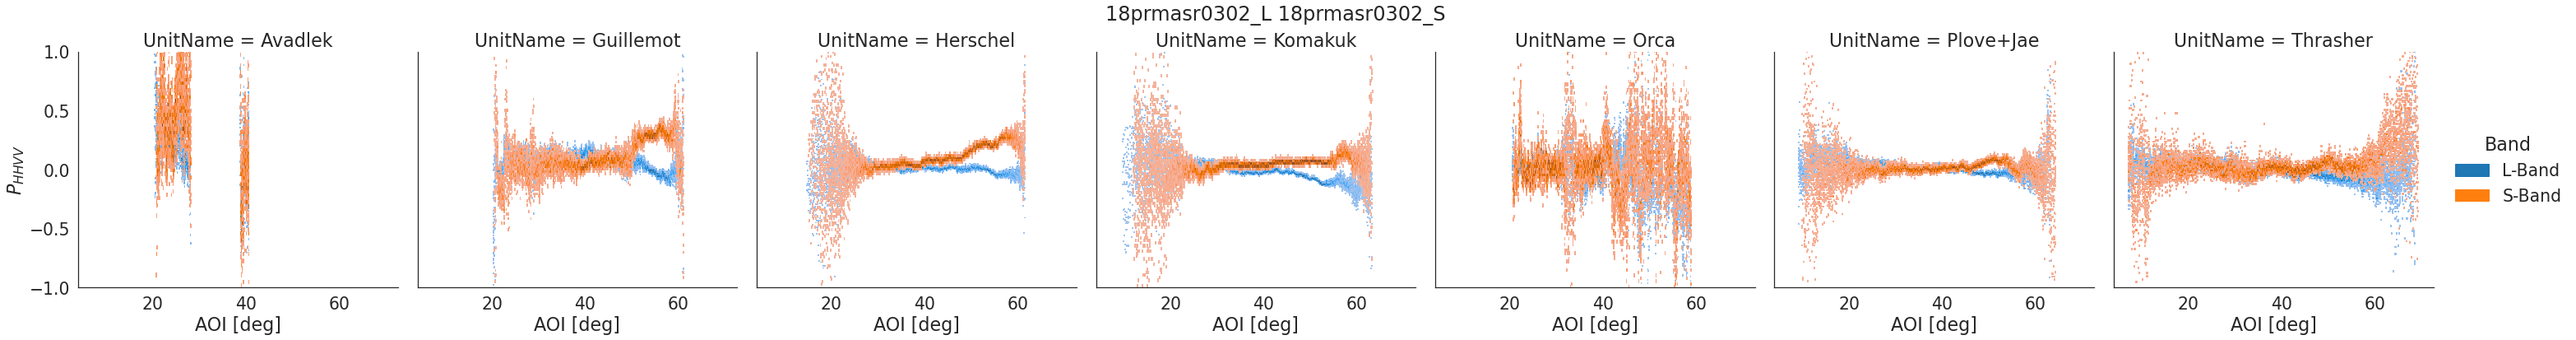

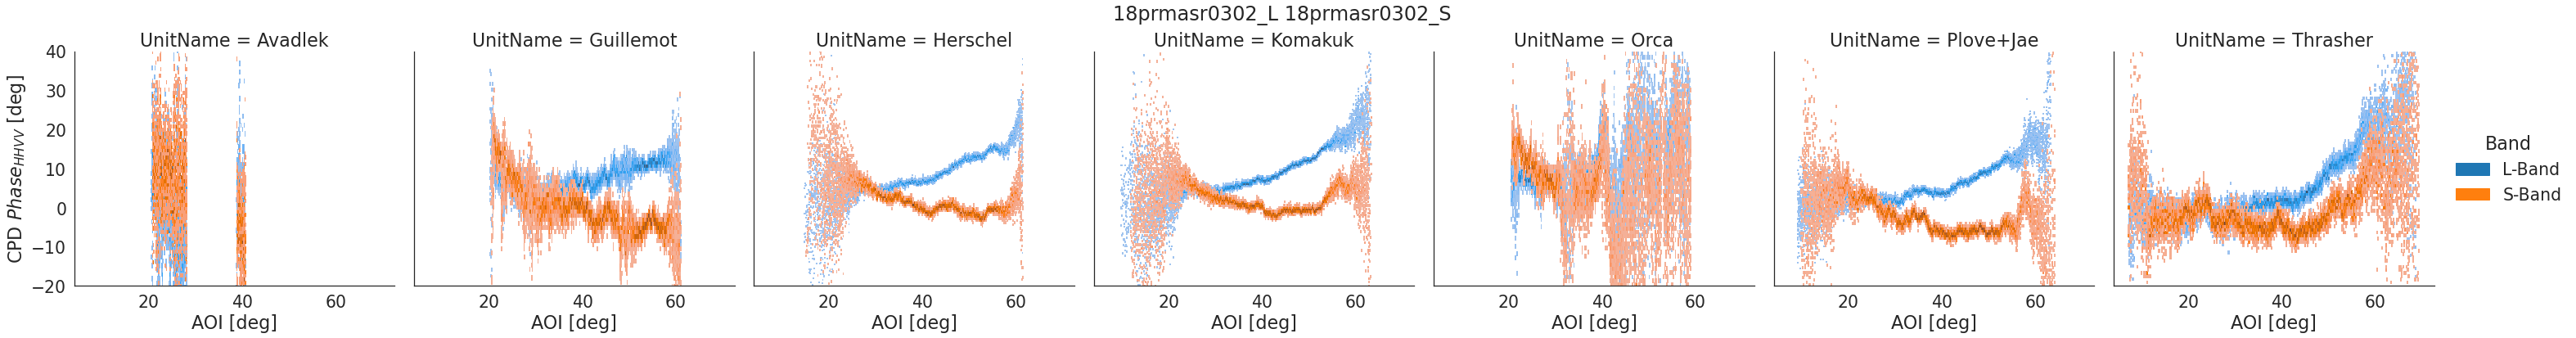

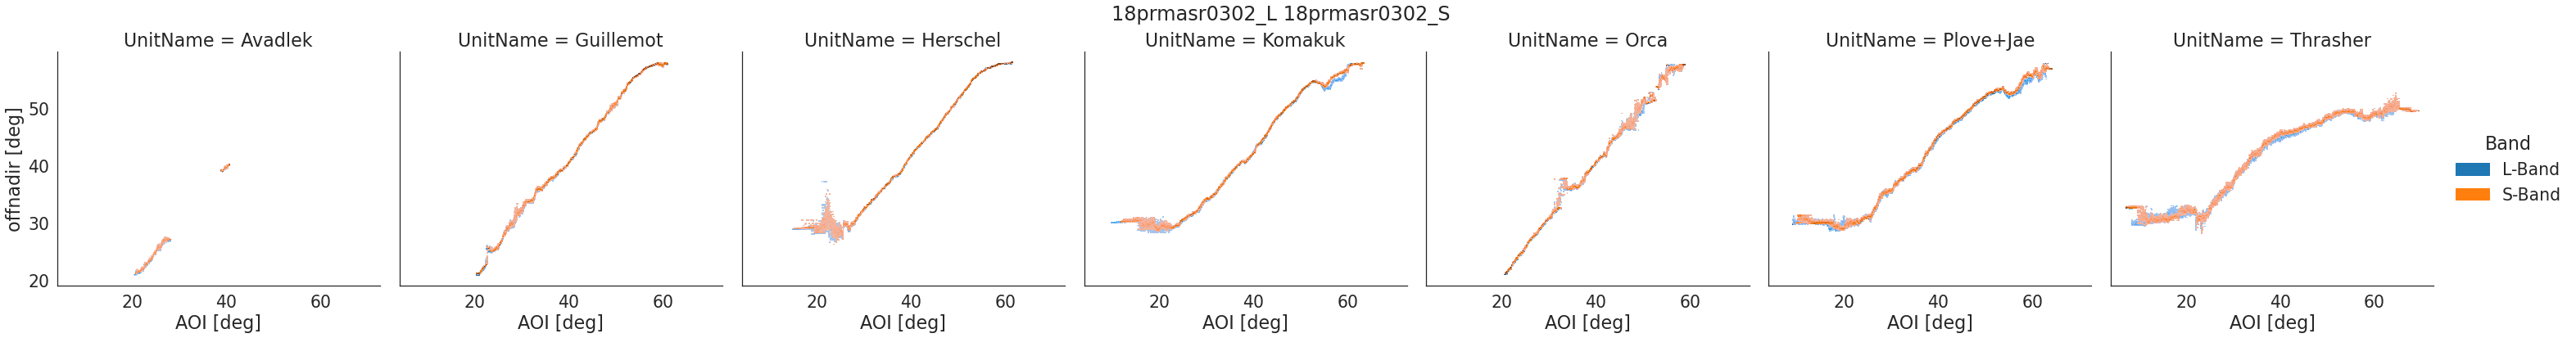

In [37]:
process_diff(ID_Pass=0, x_hist="aoi")

#############
L 1
#############
../data/processed/ecological_masks/18prmasr0303_L.nc ../data/processed/ecological_masks/19prmasr1003_L.nc
../data/processed/ecological_masks/18prmasr0303_S.nc ../data/processed/ecological_masks/19prmasr1003_S.nc
#############
Avadlek
Guillemot
Herschel
Komakuk
Orca
Plove+Jae
Thrasher
entropy
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


anisotropy
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


alpha
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


p_hhvv
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


ph_diff_hhvv
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


aoi
offnadir
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


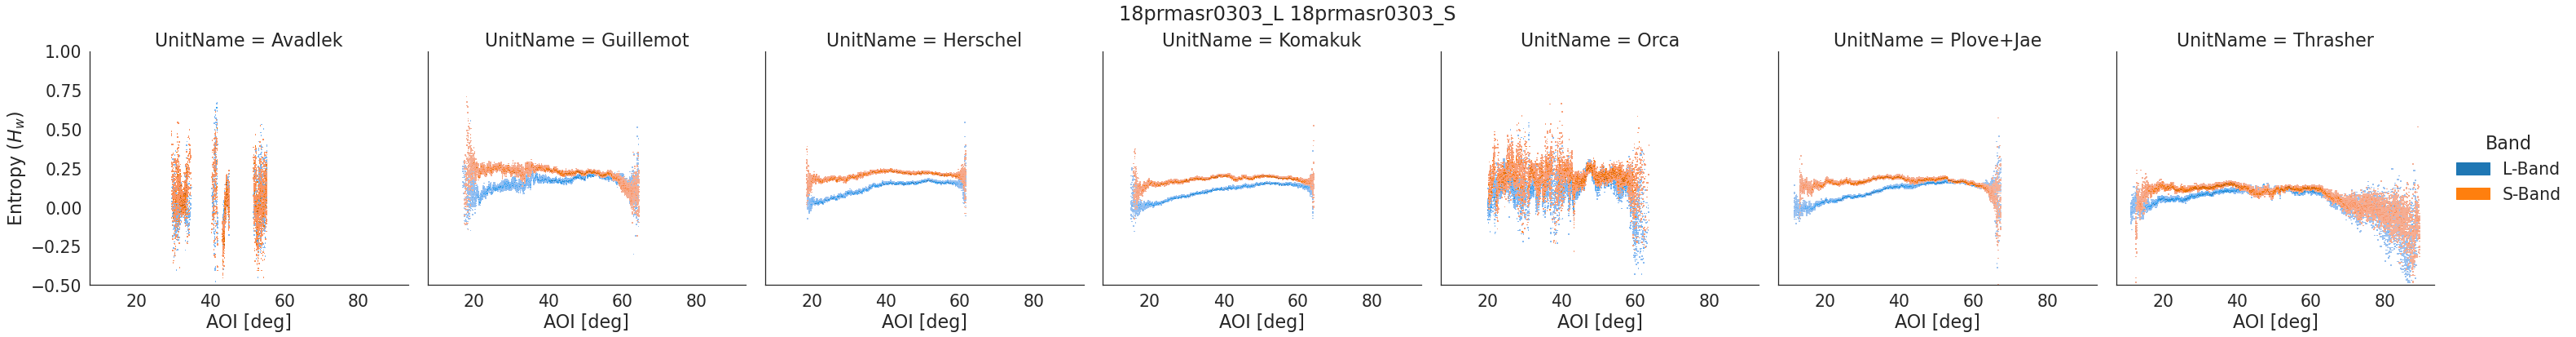

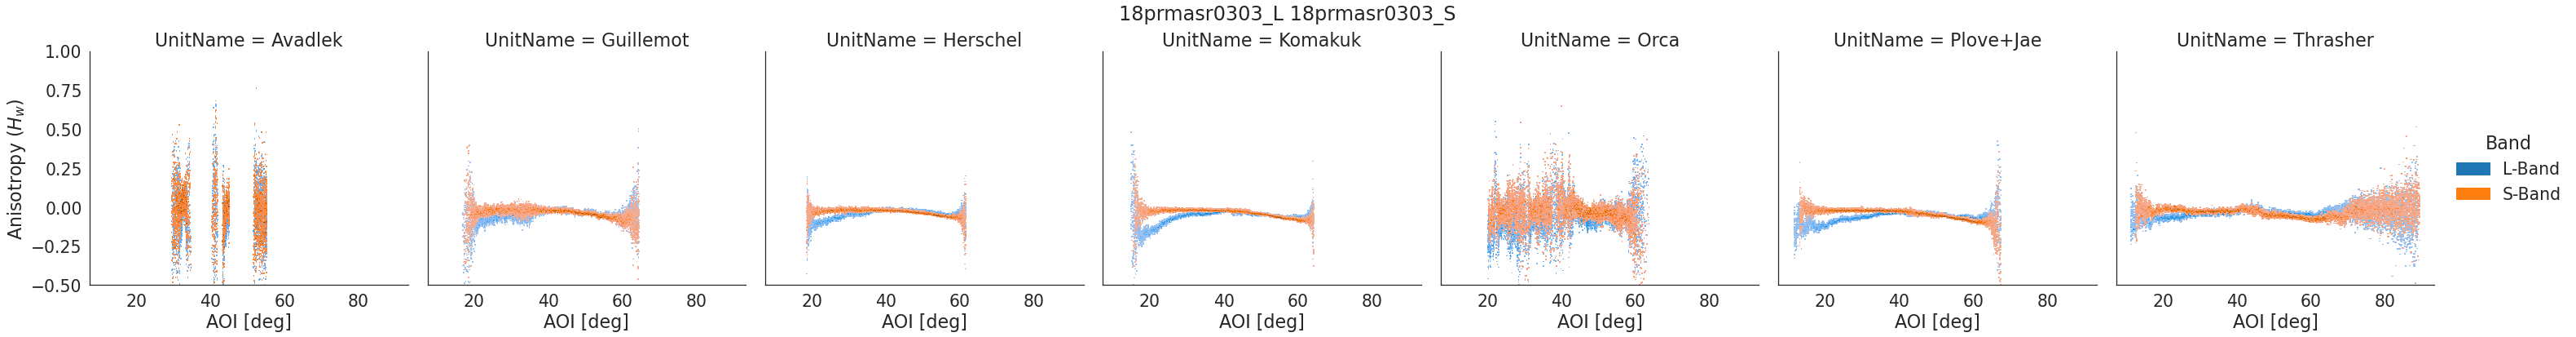

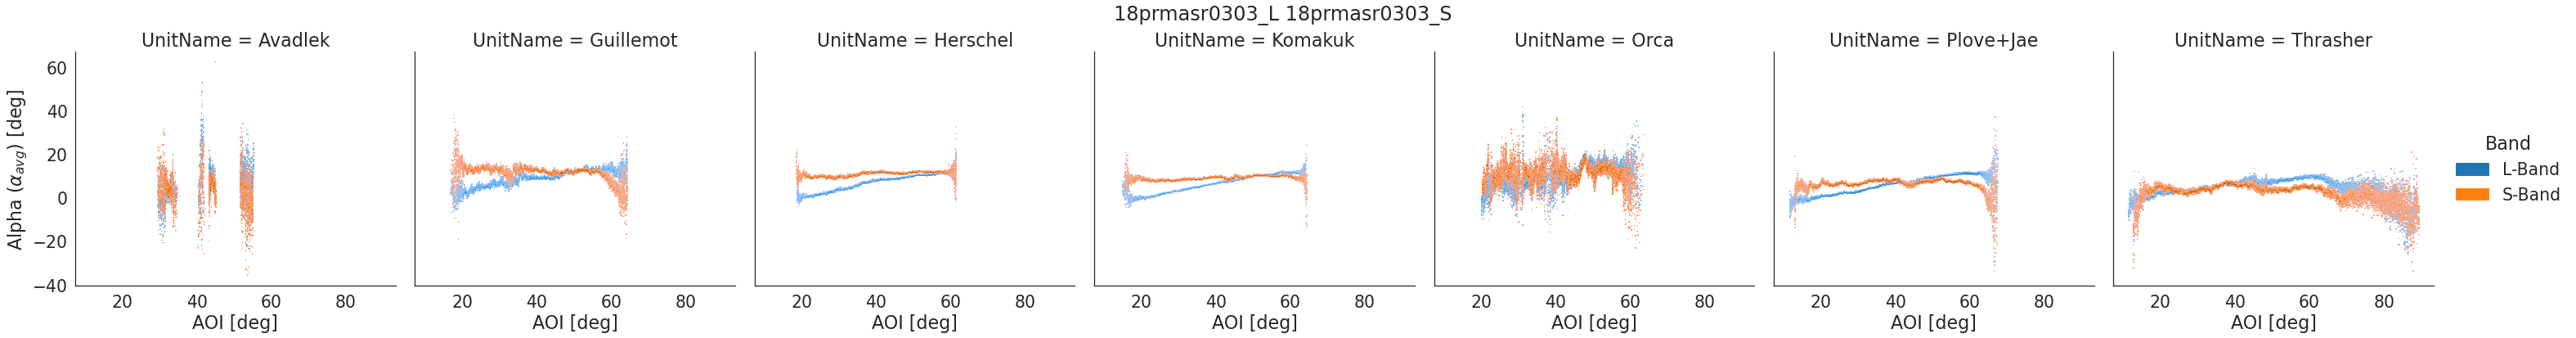

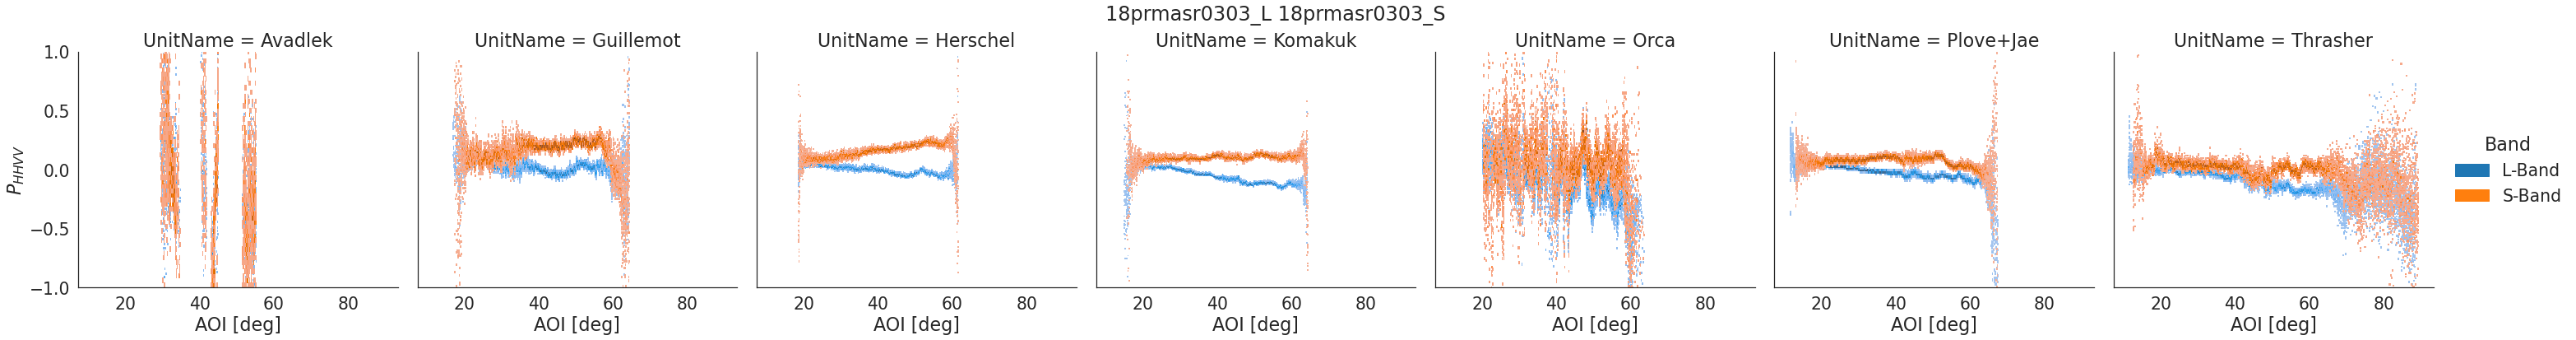

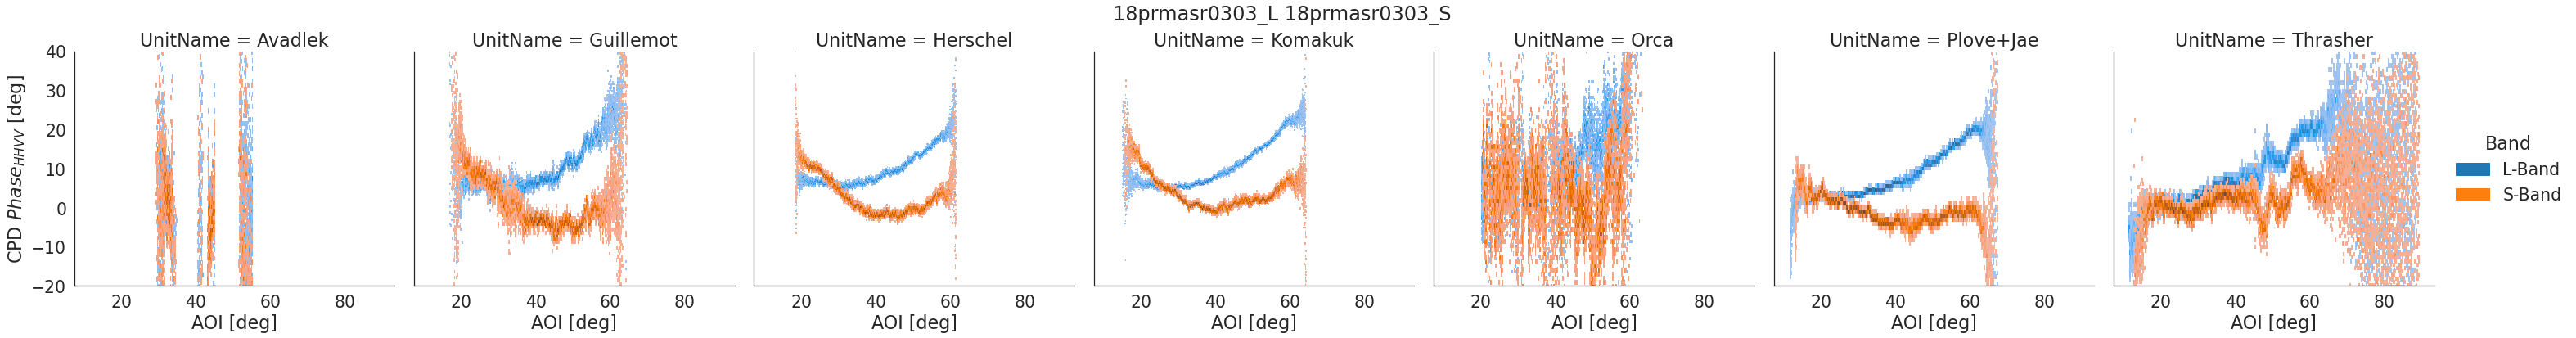

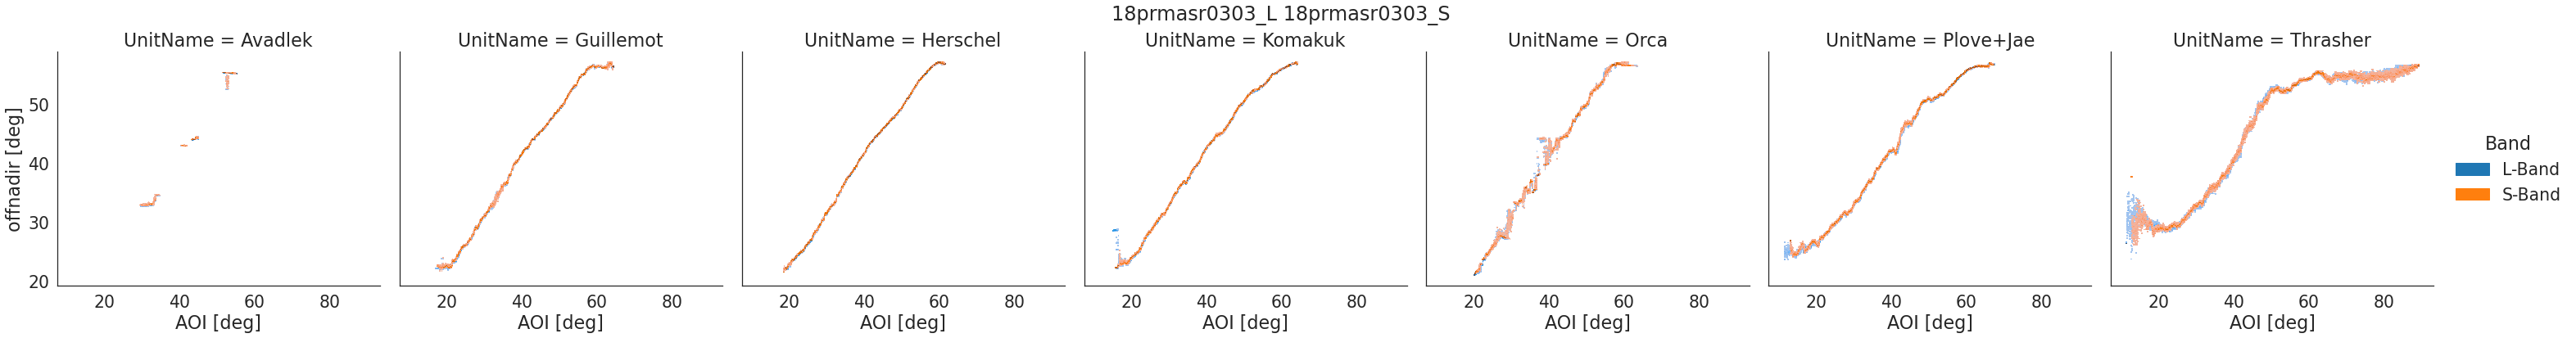

In [38]:
process_diff(ID_Pass=1, x_hist="aoi")

#############
L 0
#############
../data/processed/ecological_masks/18prmasr0302_L.nc ../data/processed/ecological_masks/19prmasr1002_L.nc
../data/processed/ecological_masks/18prmasr0302_S.nc ../data/processed/ecological_masks/19prmasr1002_S.nc
#############
Avadlek
Guillemot
Herschel
Komakuk
Orca
Plove+Jae
Thrasher
entropy
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


anisotropy
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


alpha
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


p_hhvv
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


ph_diff_hhvv
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


aoi
offnadir
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


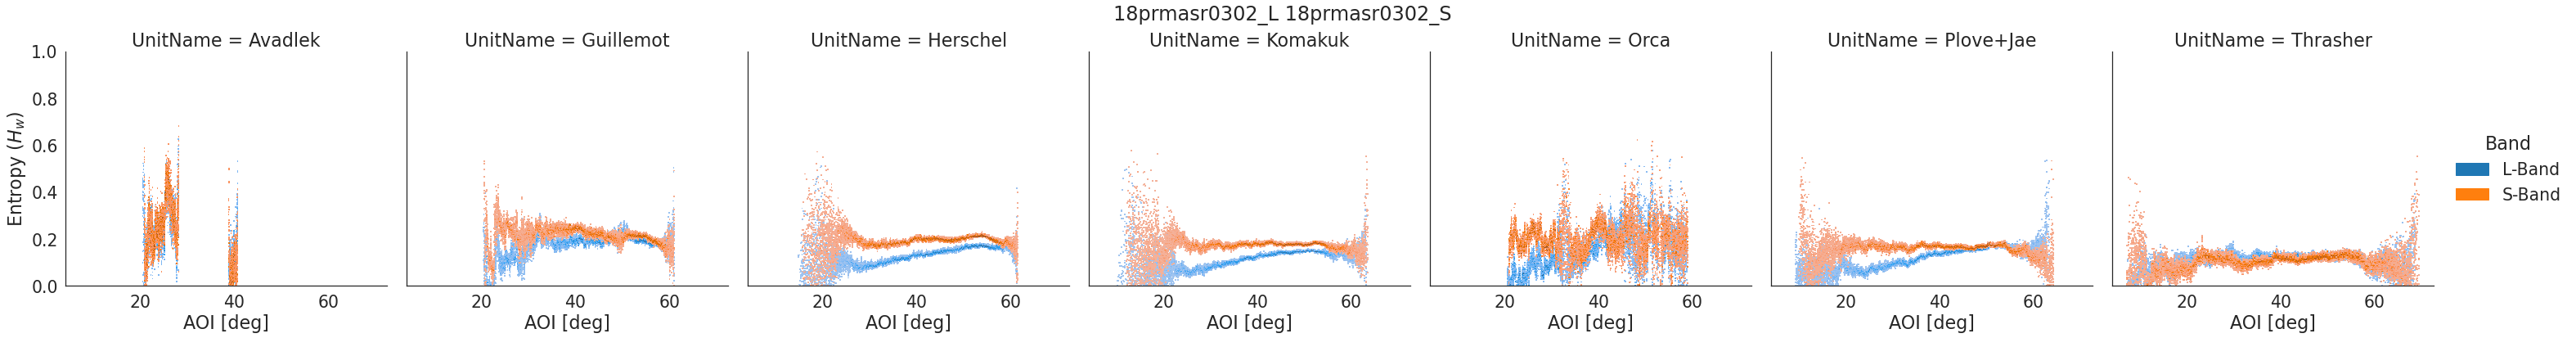

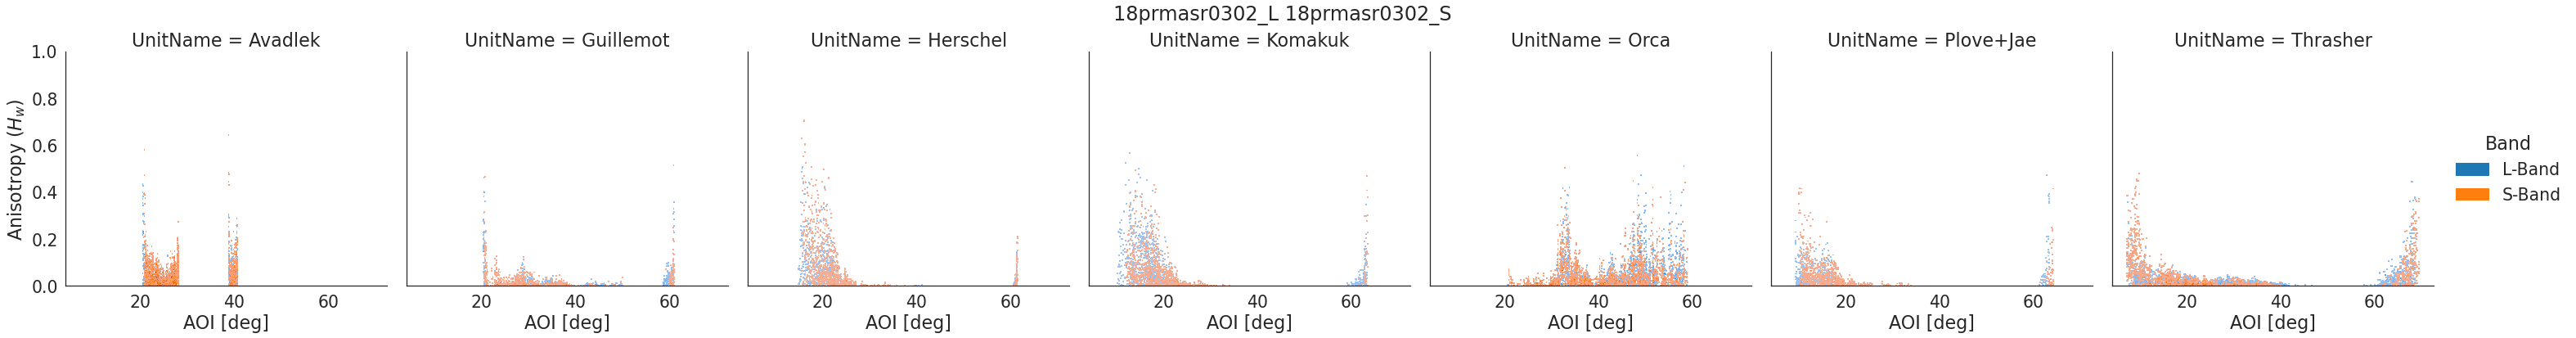

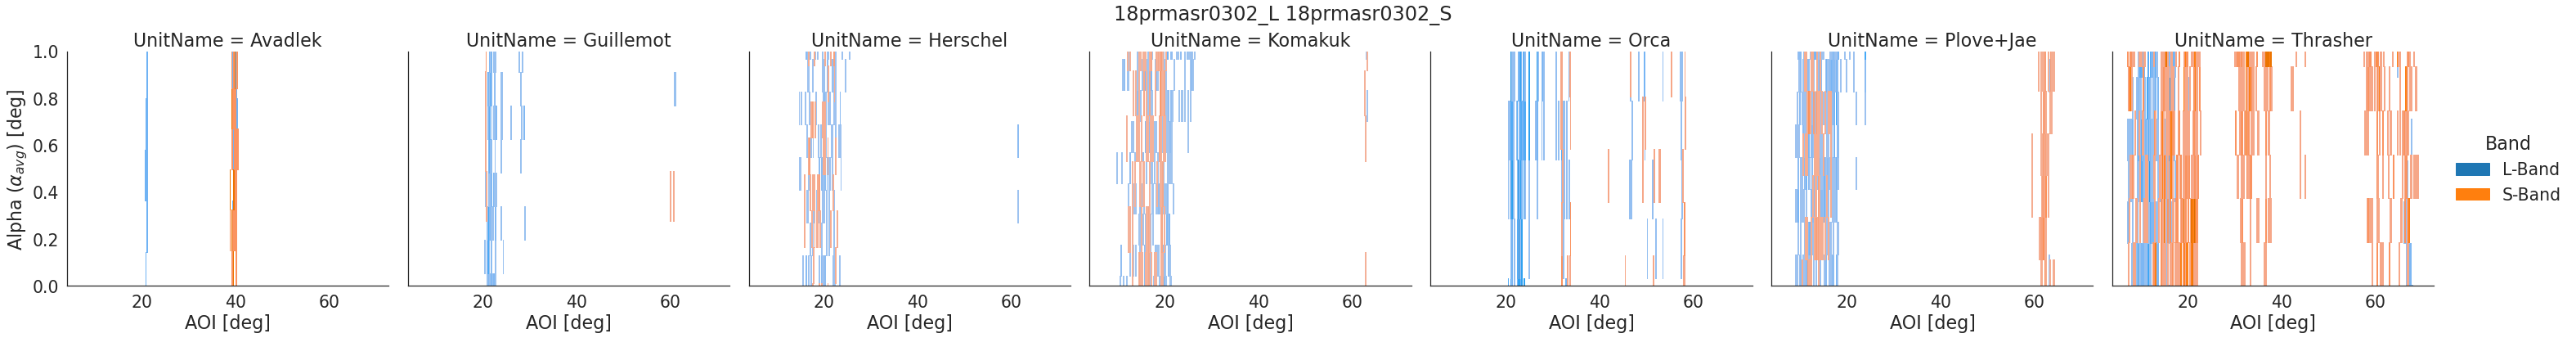

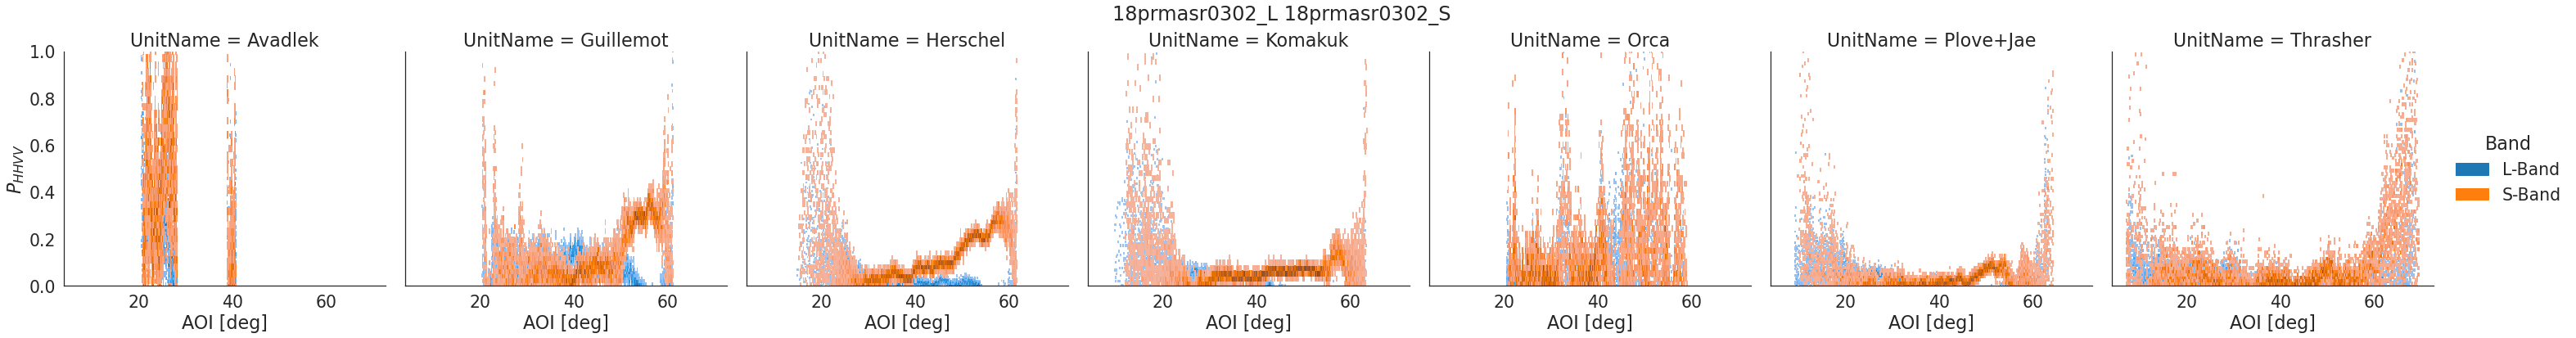

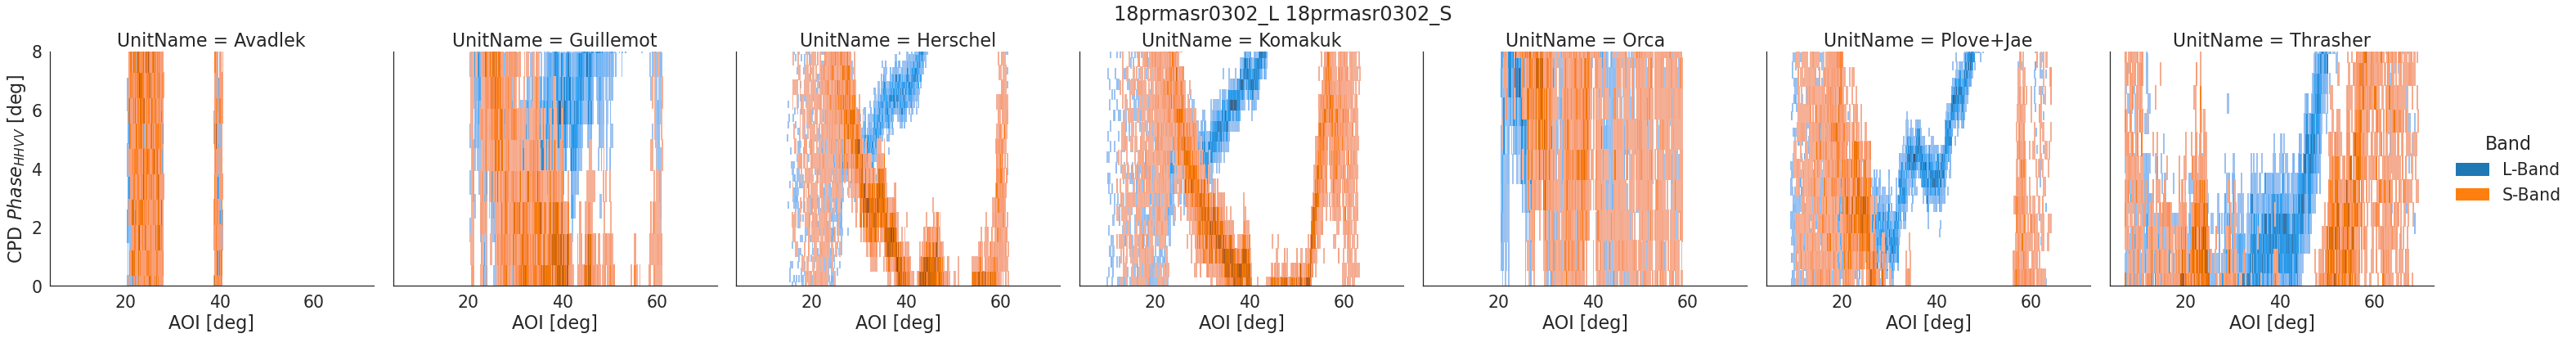

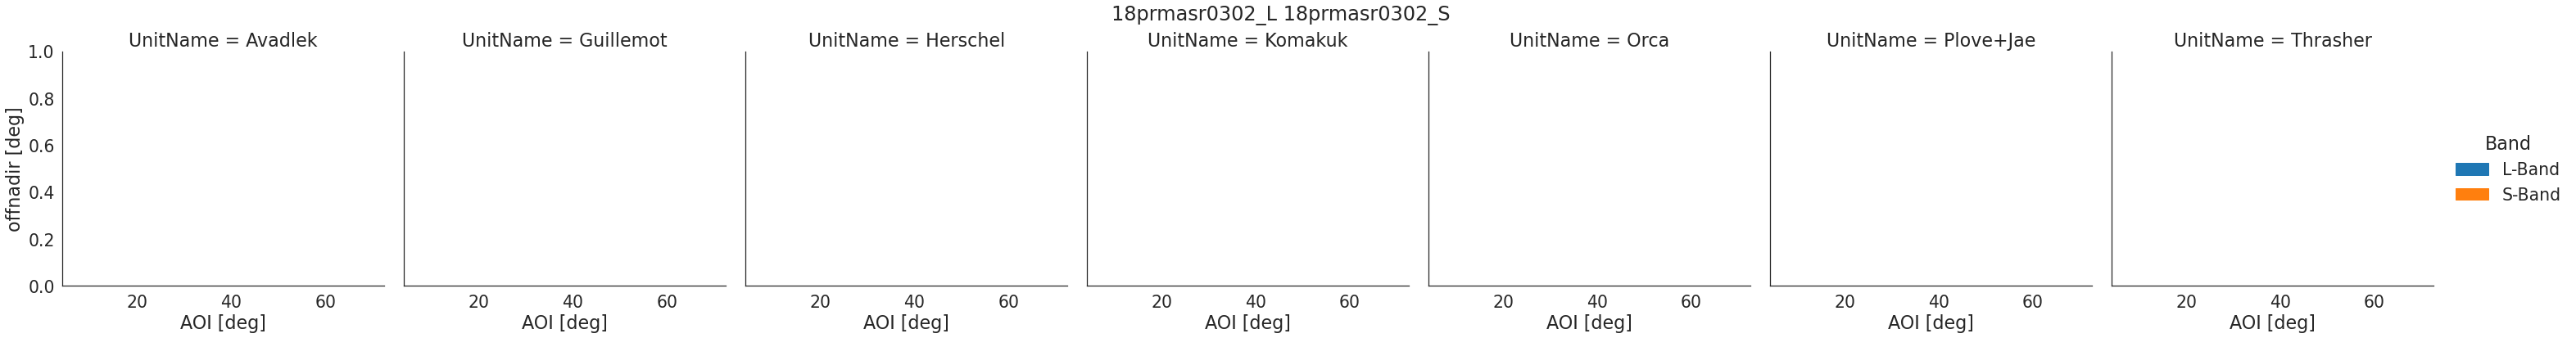

In [35]:
process_diff(ID_Pass=0, x_hist="aoi")

In [ ]:
process_diff(ID_Pass=1, x_hist="aoi")

#############
L 0
#############
../data/processed/ecological_masks/18prmasr0302_L.nc ../data/processed/ecological_masks/19prmasr1002_L.nc
../data/processed/ecological_masks/18prmasr0302_S.nc ../data/processed/ecological_masks/19prmasr1002_S.nc
#############
Avadlek
Guillemot
Herschel
Komakuk
Orca
Plove+Jae
Thrasher
entropy
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1002_L 19prmasr1002_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


anisotropy
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1002_L 19prmasr1002_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


alpha
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1002_L 19prmasr1002_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


p_hhvv
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1002_L 19prmasr1002_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


ph_diff_hhvv
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1002_L 19prmasr1002_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


aoi
offnadir
Save Figure 18prmasr0302_L 18prmasr0302_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1002_L 19prmasr1002_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


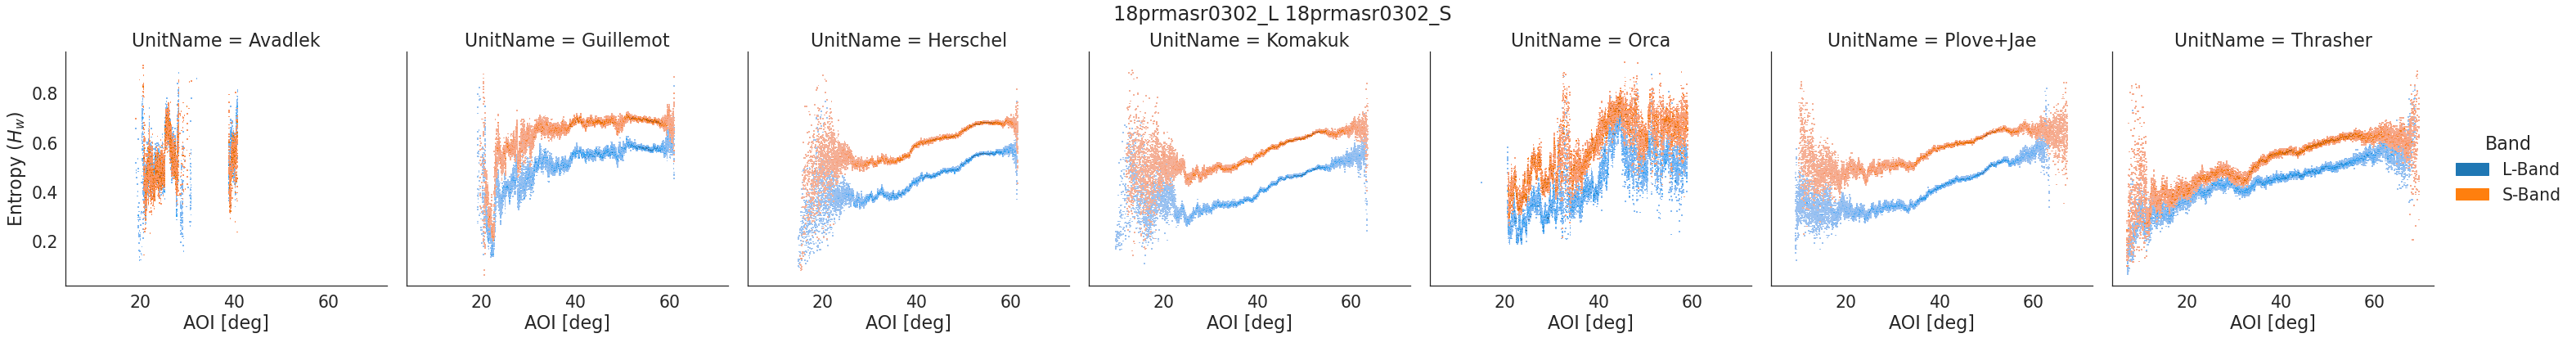

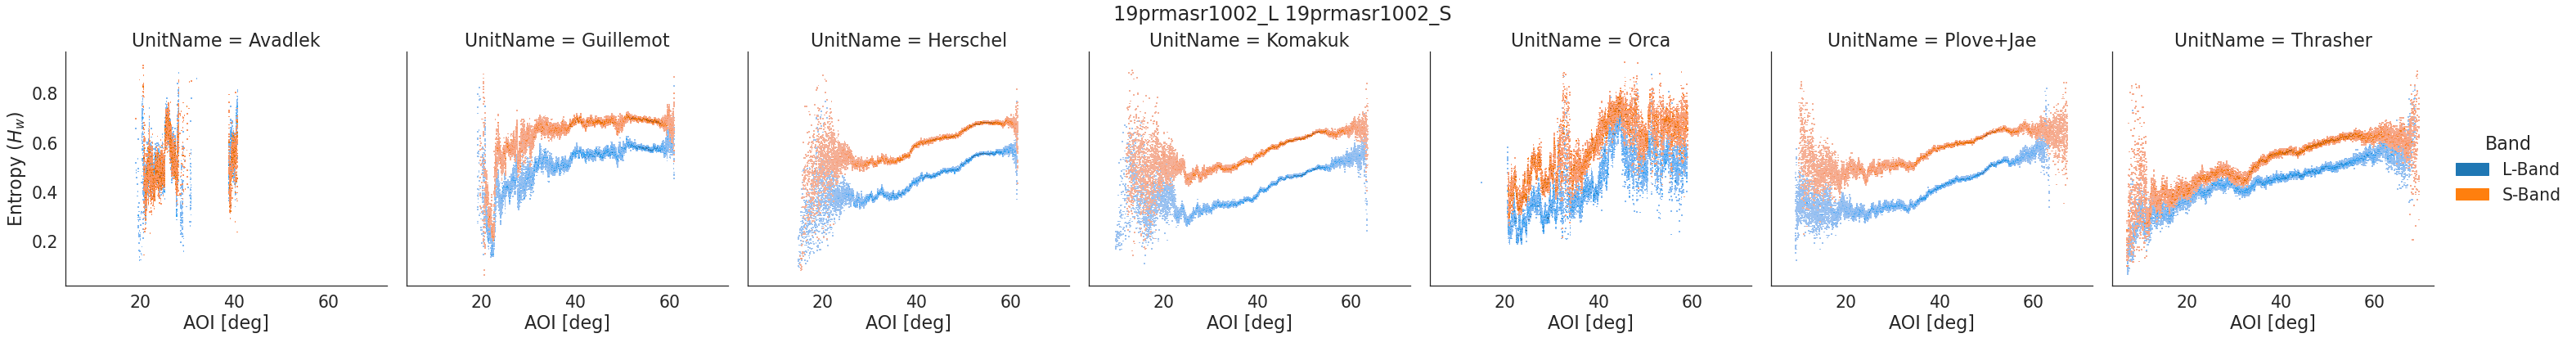

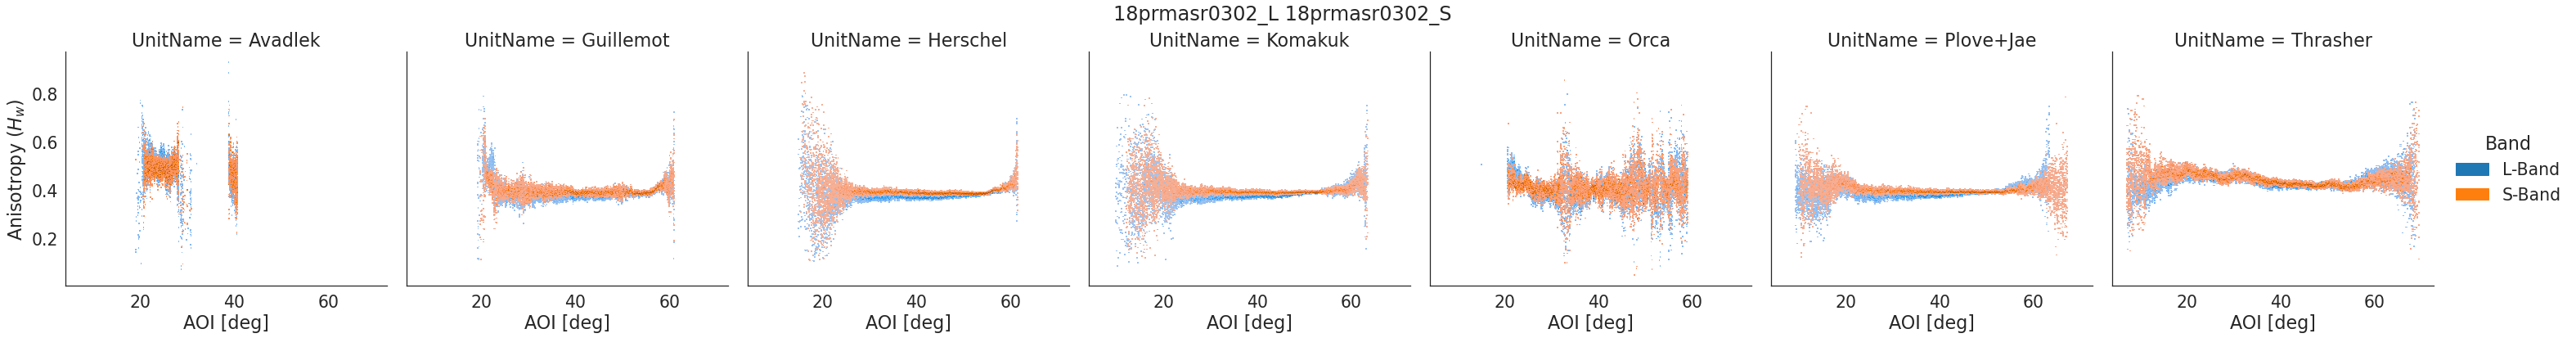

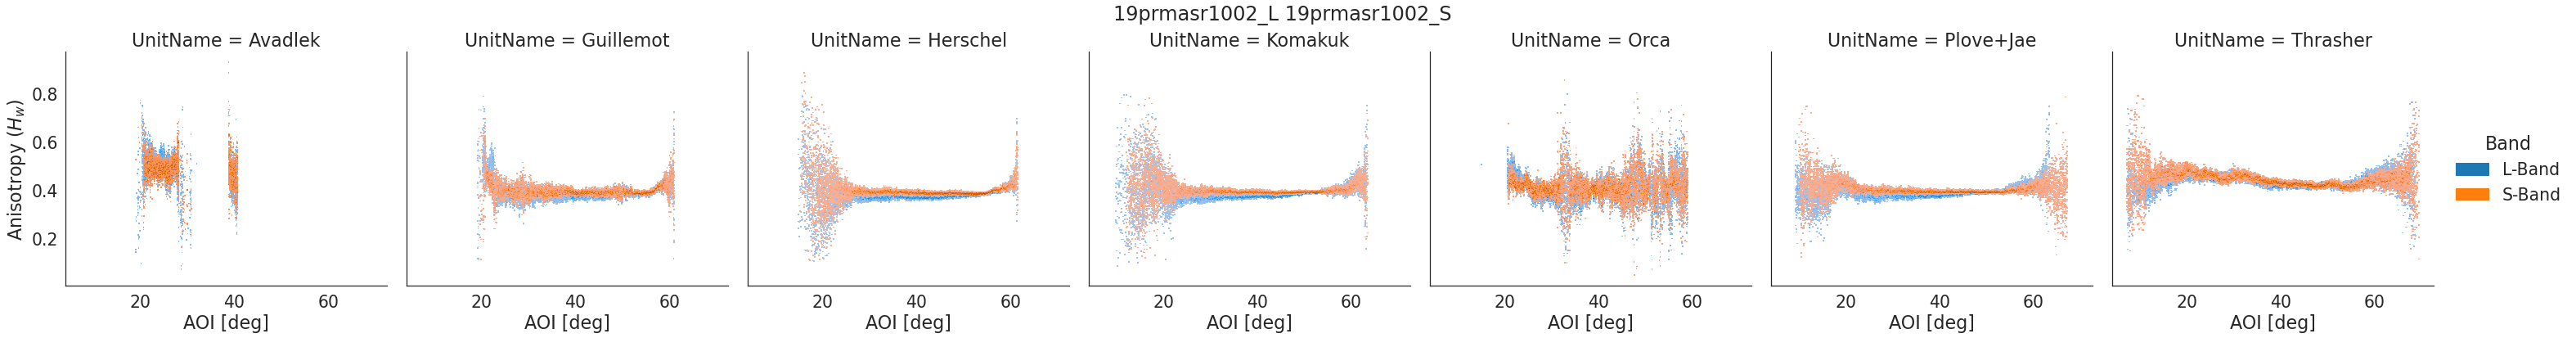

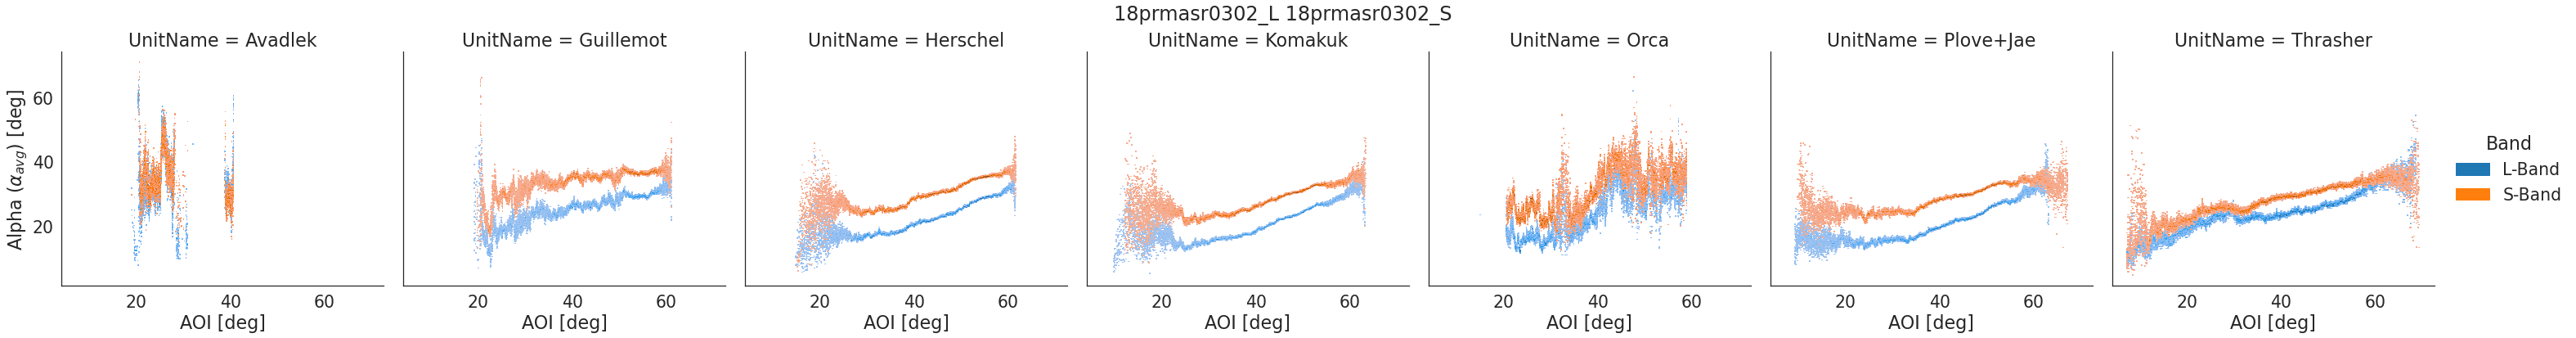

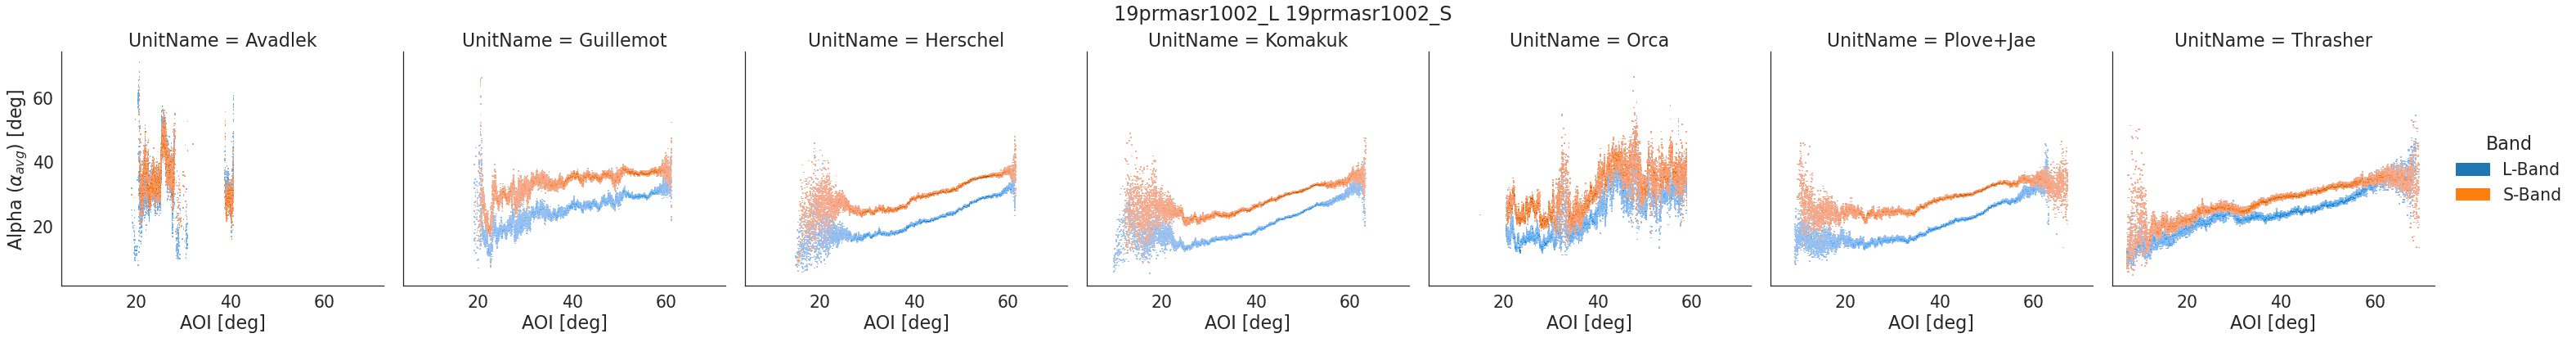

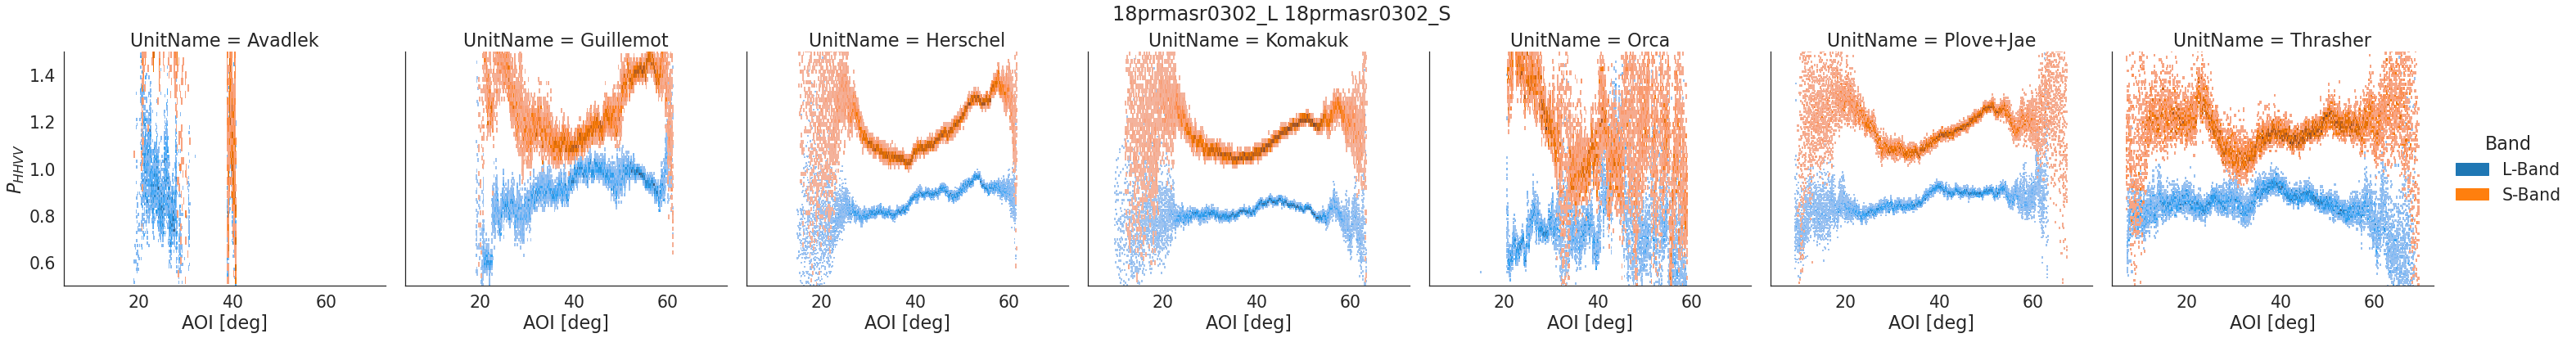

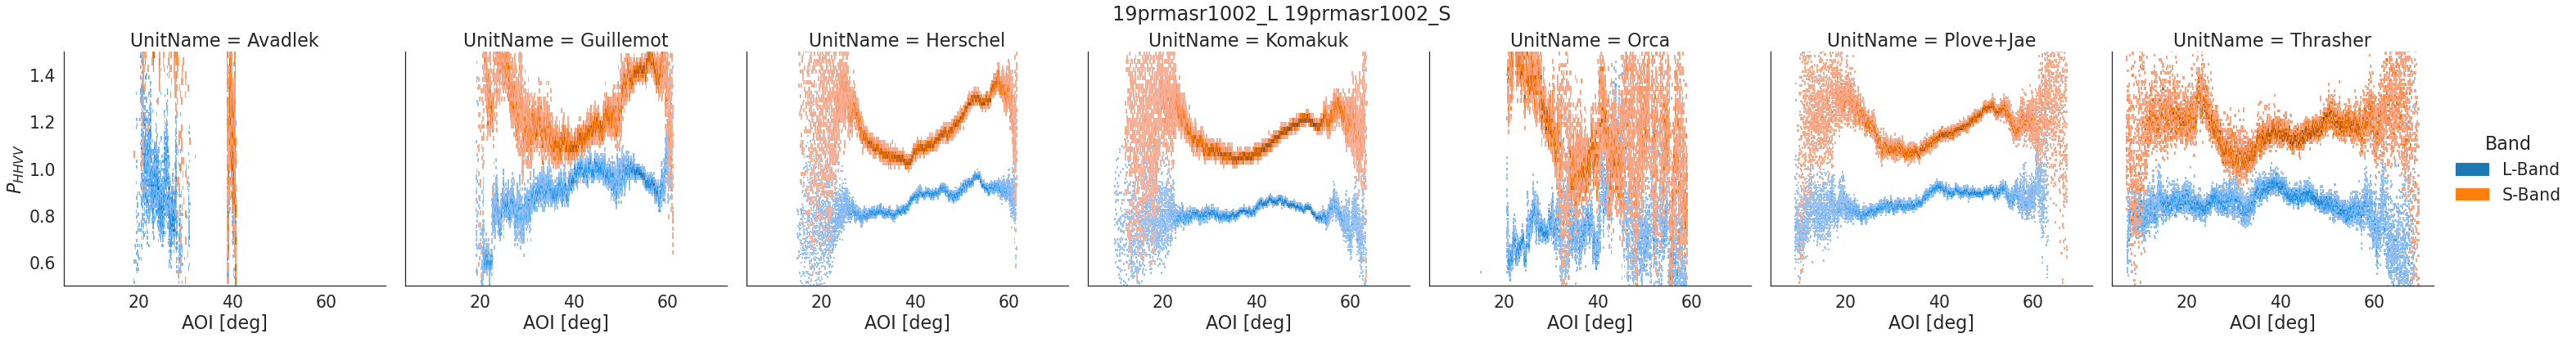

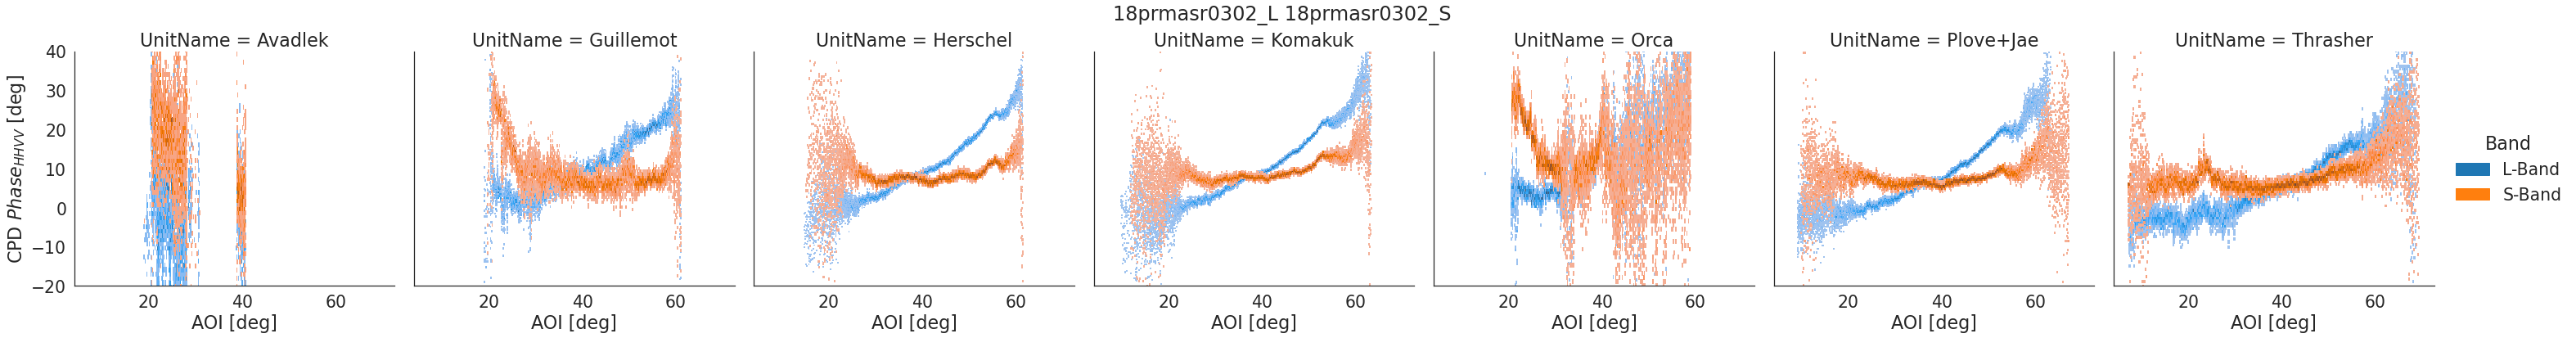

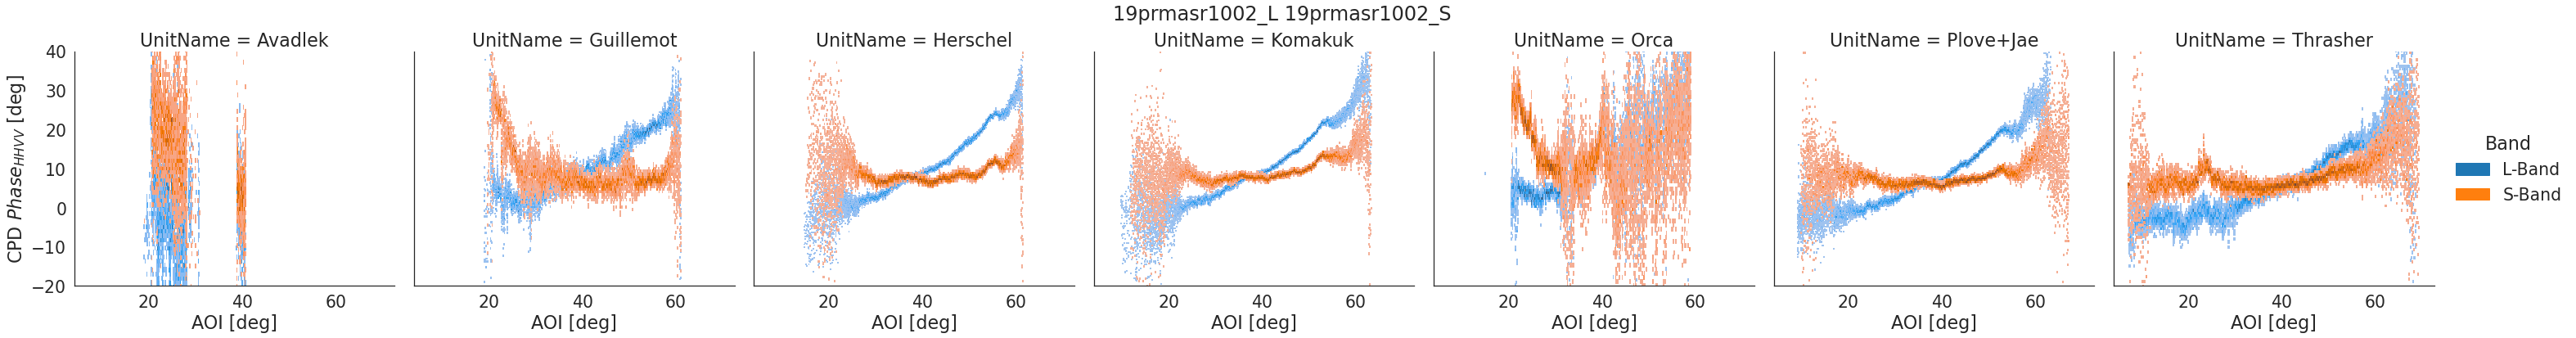

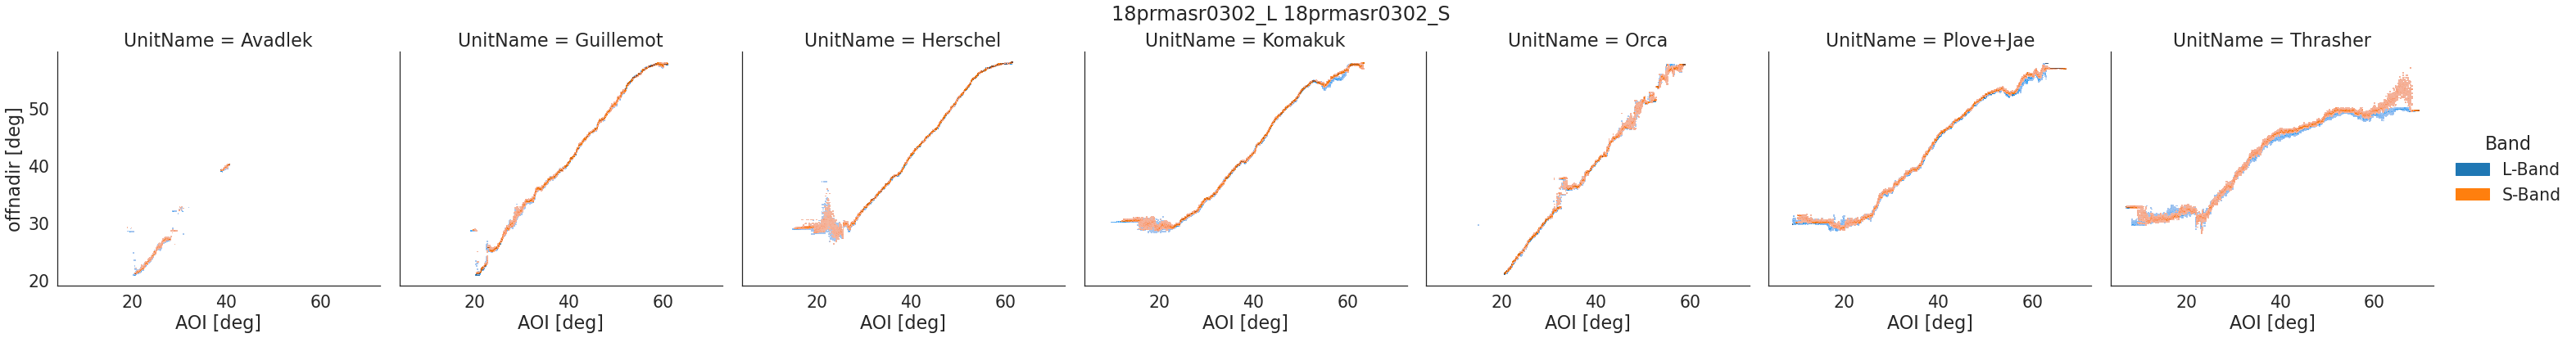

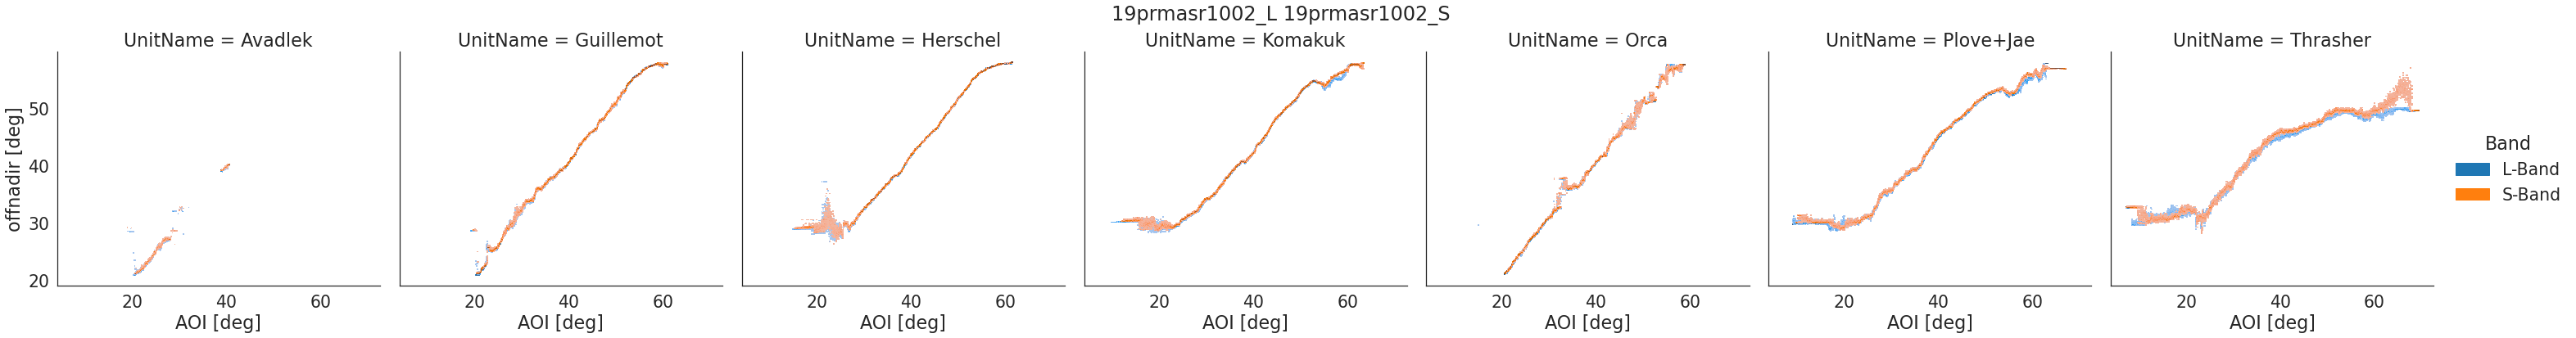

In [27]:
process(ID_Pass=0, x_hist="aoi")

#############
L 1
#############
../data/processed/ecological_masks/18prmasr0303_L.nc ../data/processed/ecological_masks/19prmasr1003_L.nc
../data/processed/ecological_masks/18prmasr0303_S.nc ../data/processed/ecological_masks/19prmasr1003_S.nc
#############
Avadlek
Guillemot
Herschel
Komakuk
Orca
Plove+Jae
Thrasher
entropy
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1003_L 19prmasr1003_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


anisotropy
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1003_L 19prmasr1003_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


alpha
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1003_L 19prmasr1003_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


p_hhvv
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1003_L 19prmasr1003_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


ph_diff_hhvv
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1003_L 19prmasr1003_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


aoi
offnadir
Save Figure 18prmasr0303_L 18prmasr0303_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1003_L 19prmasr1003_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


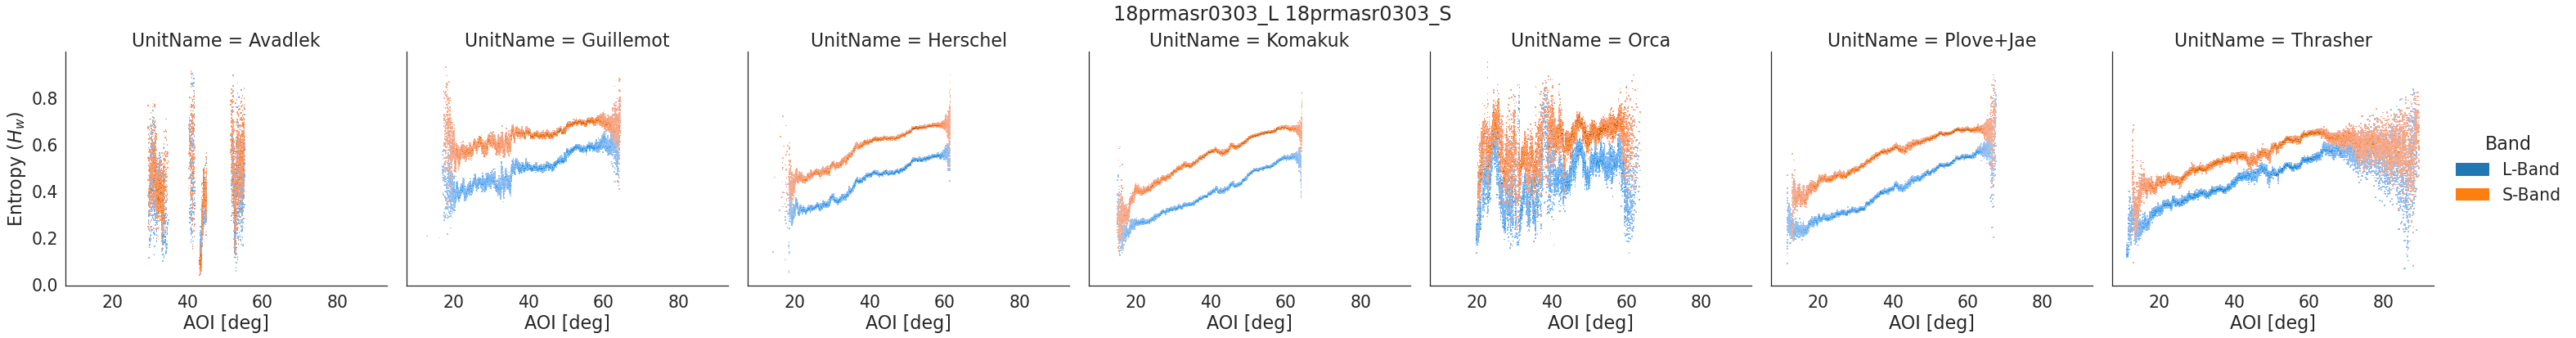

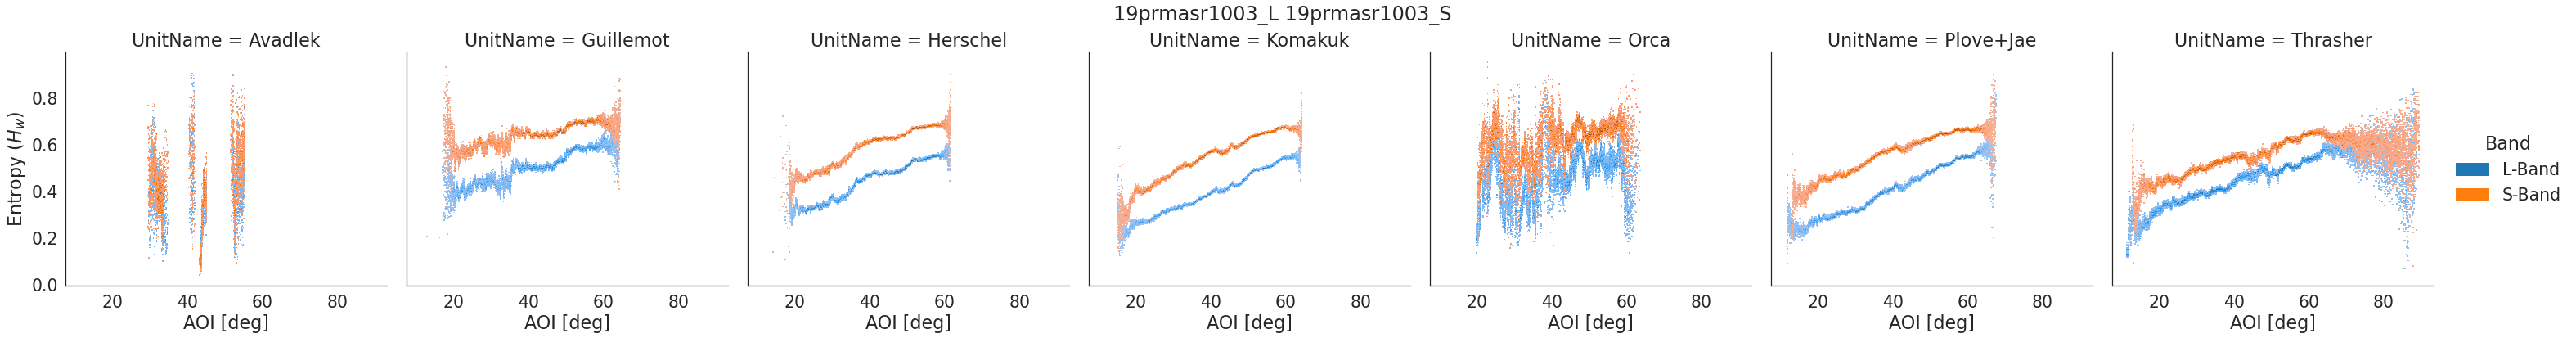

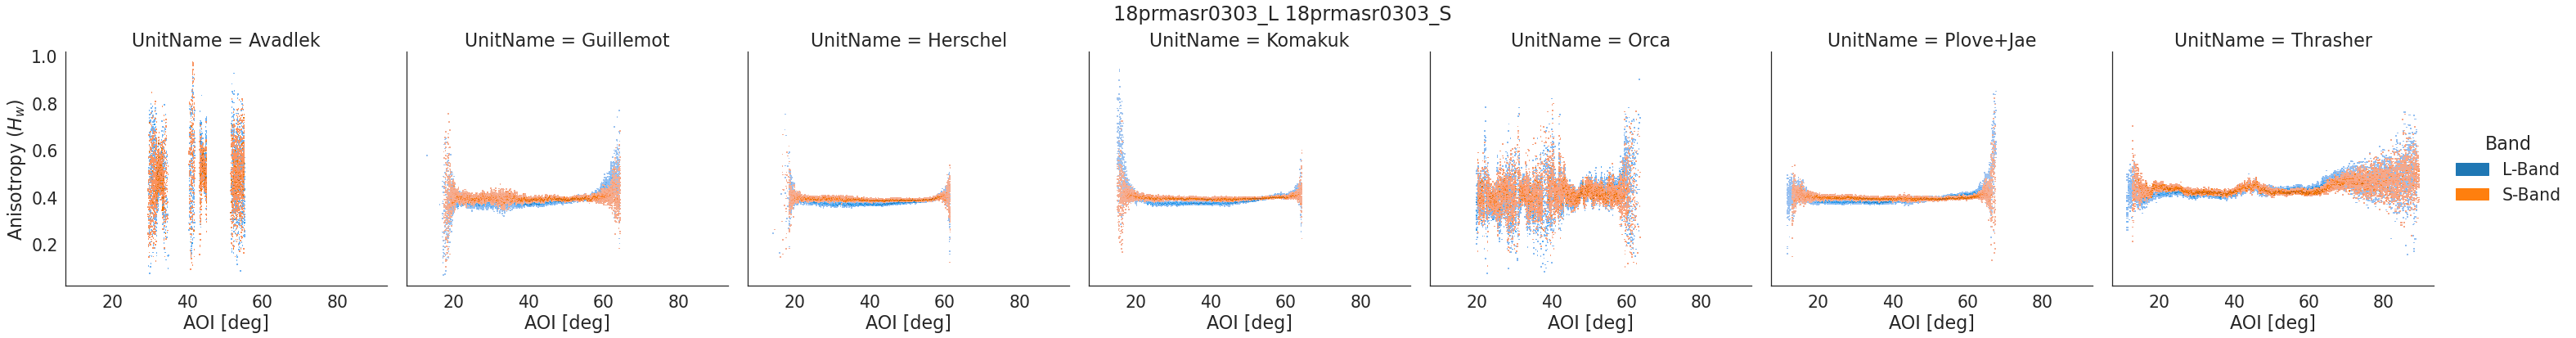

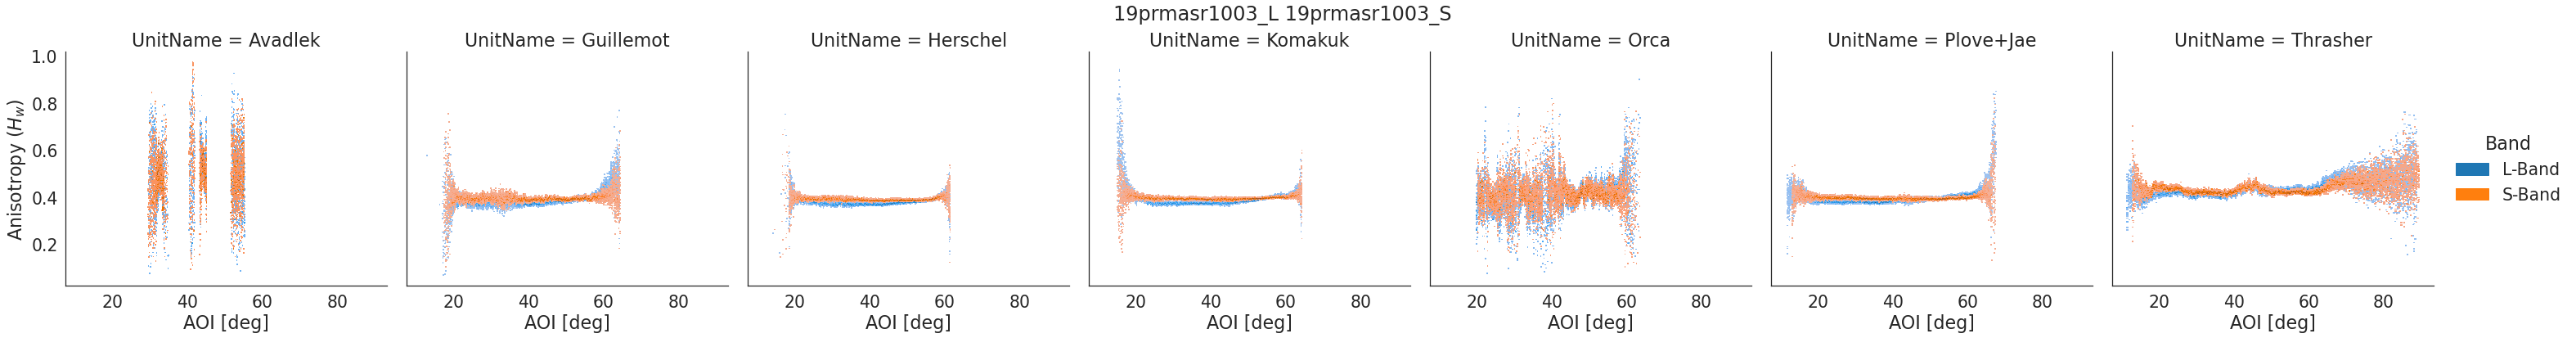

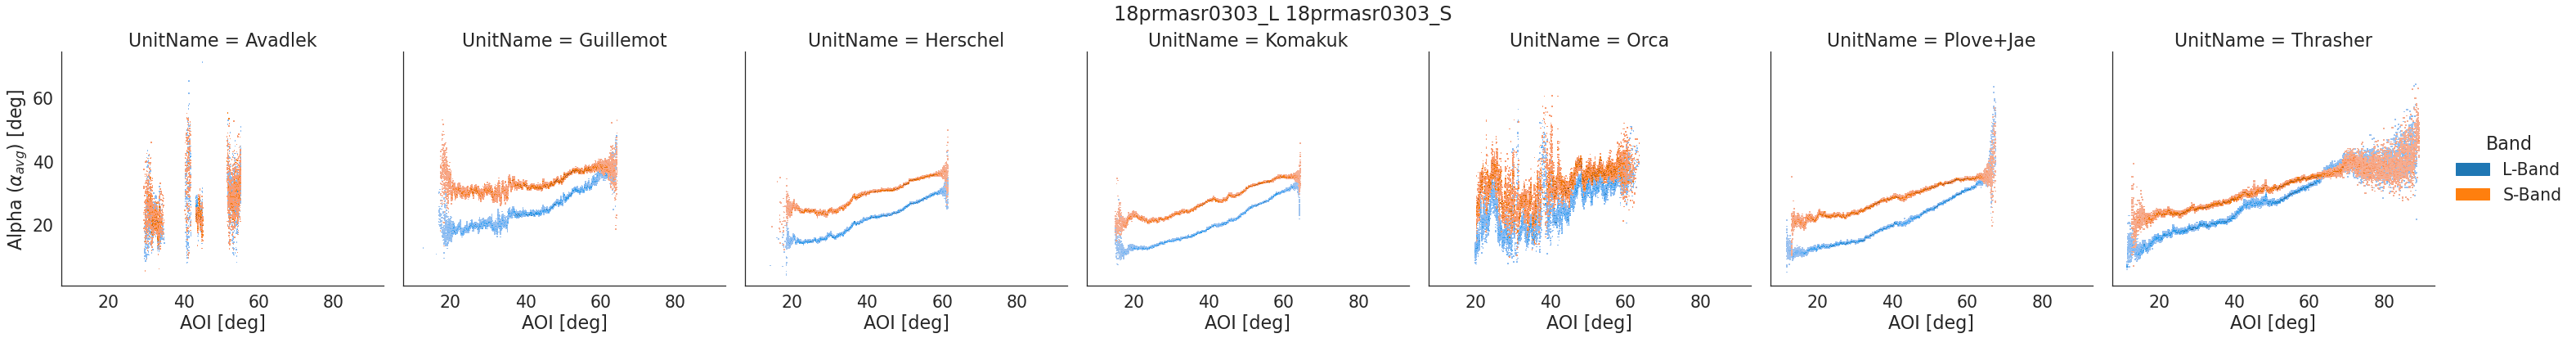

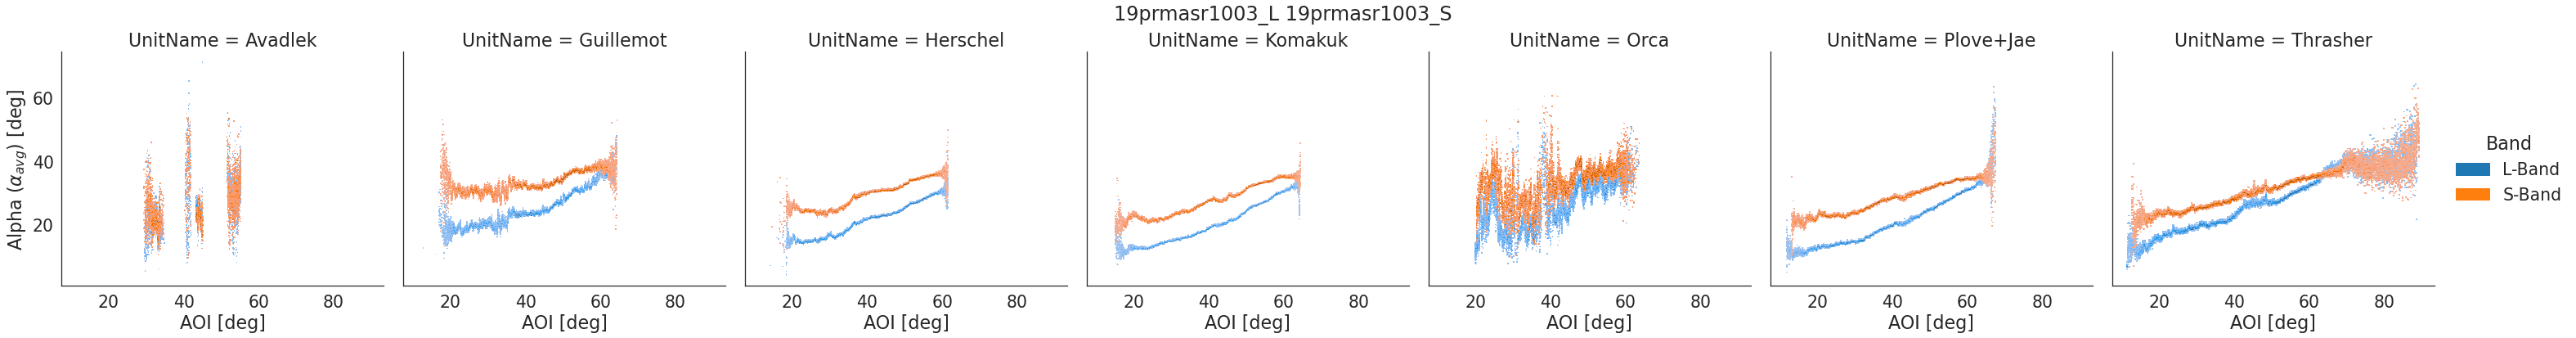

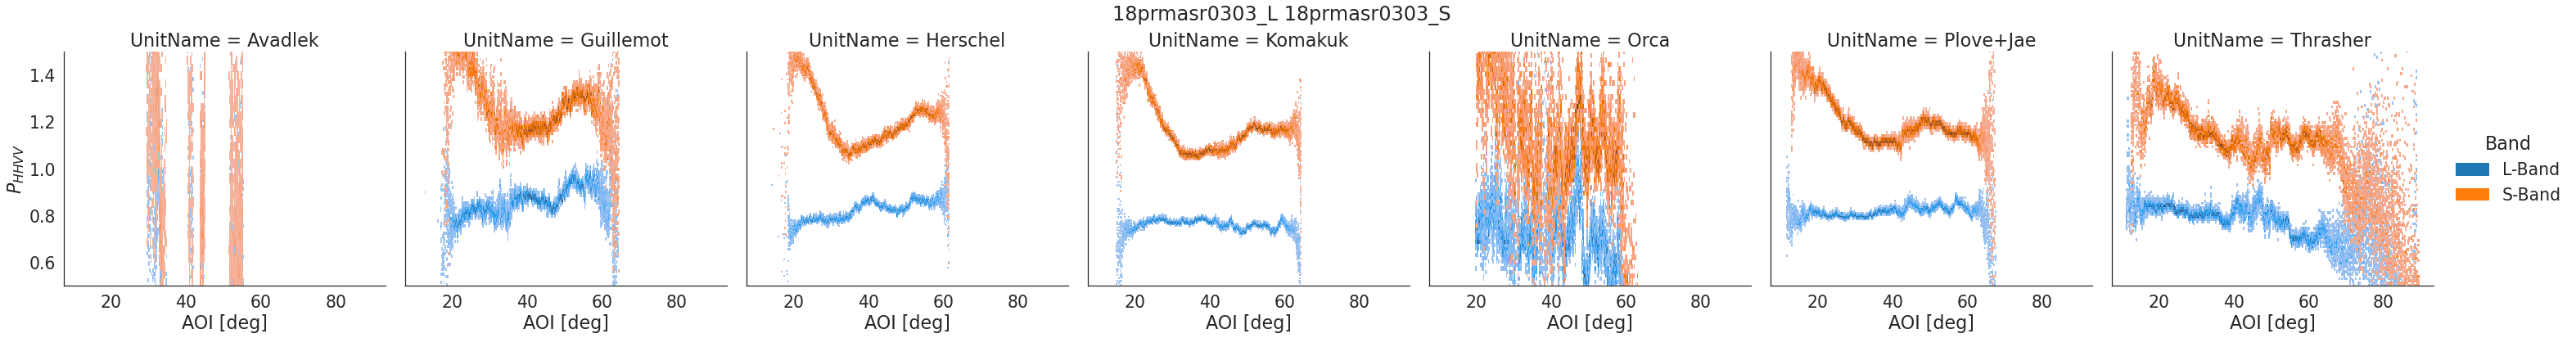

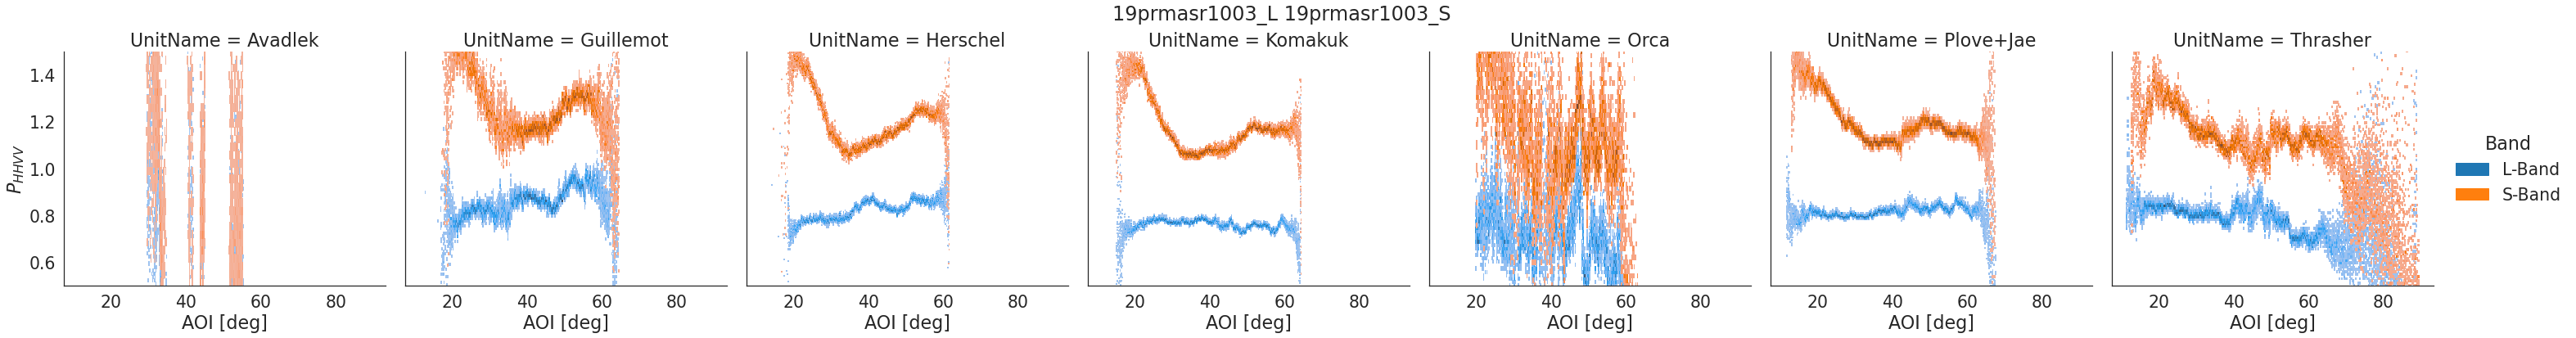

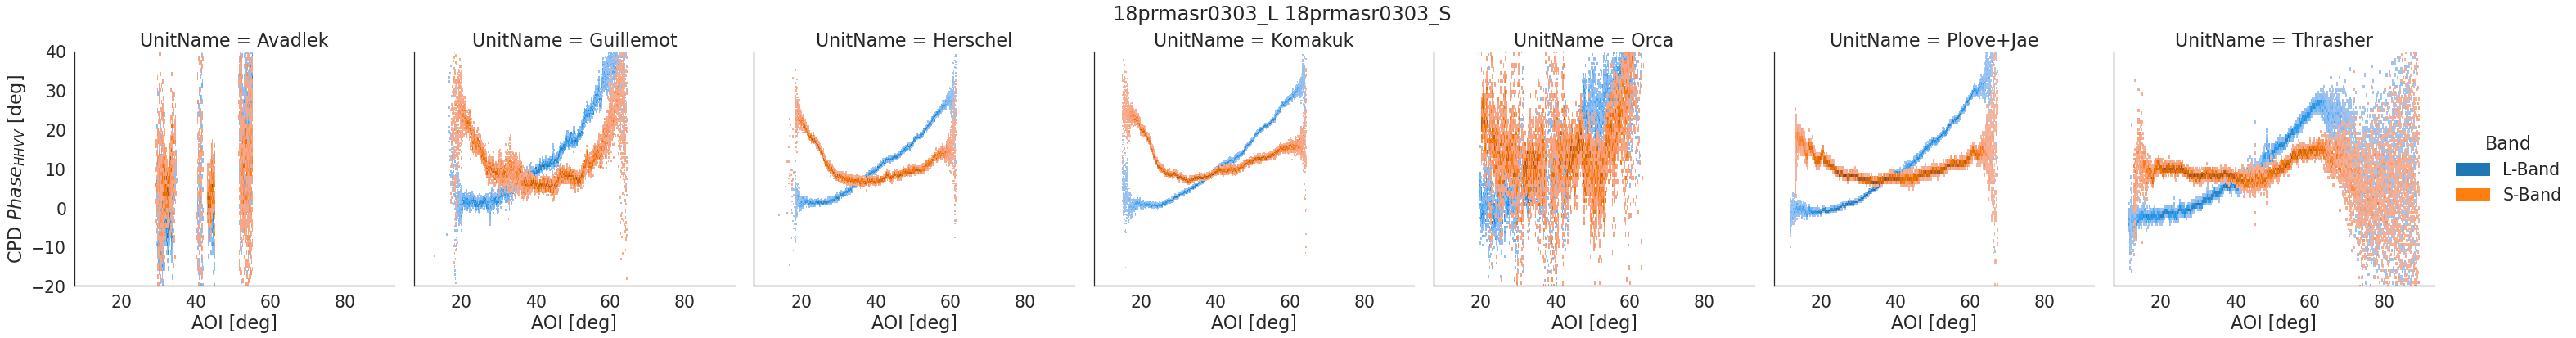

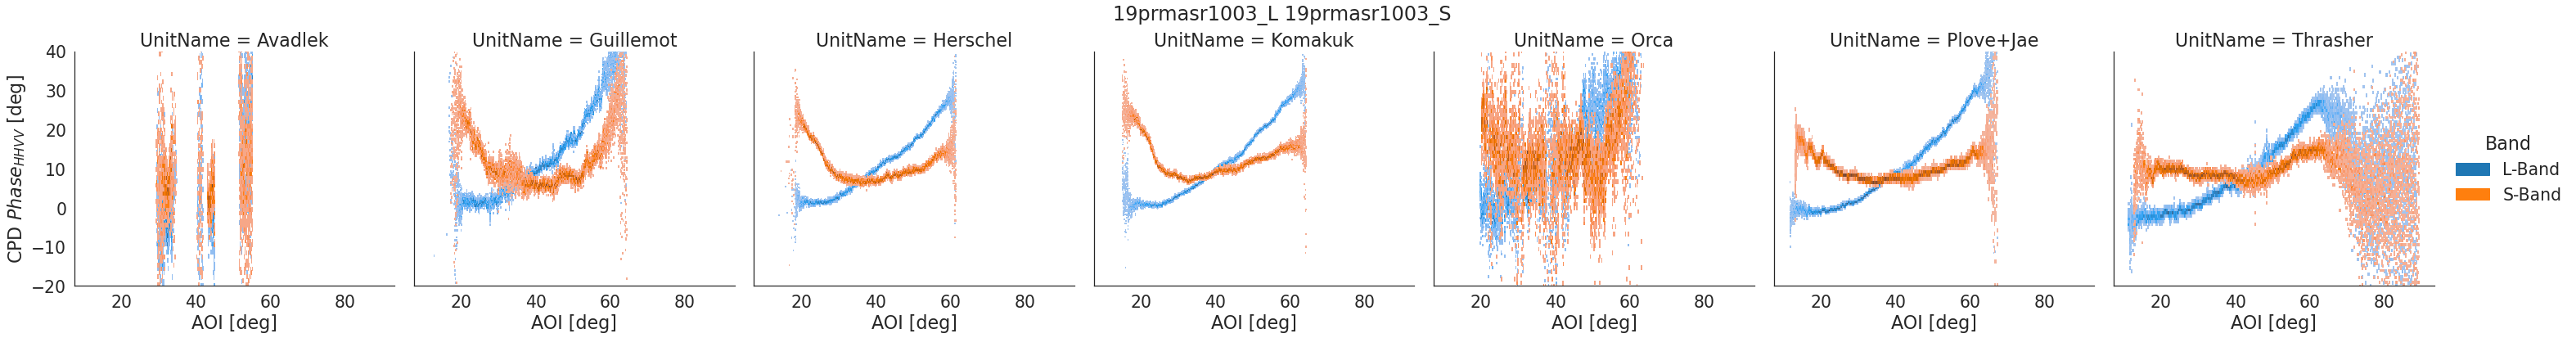

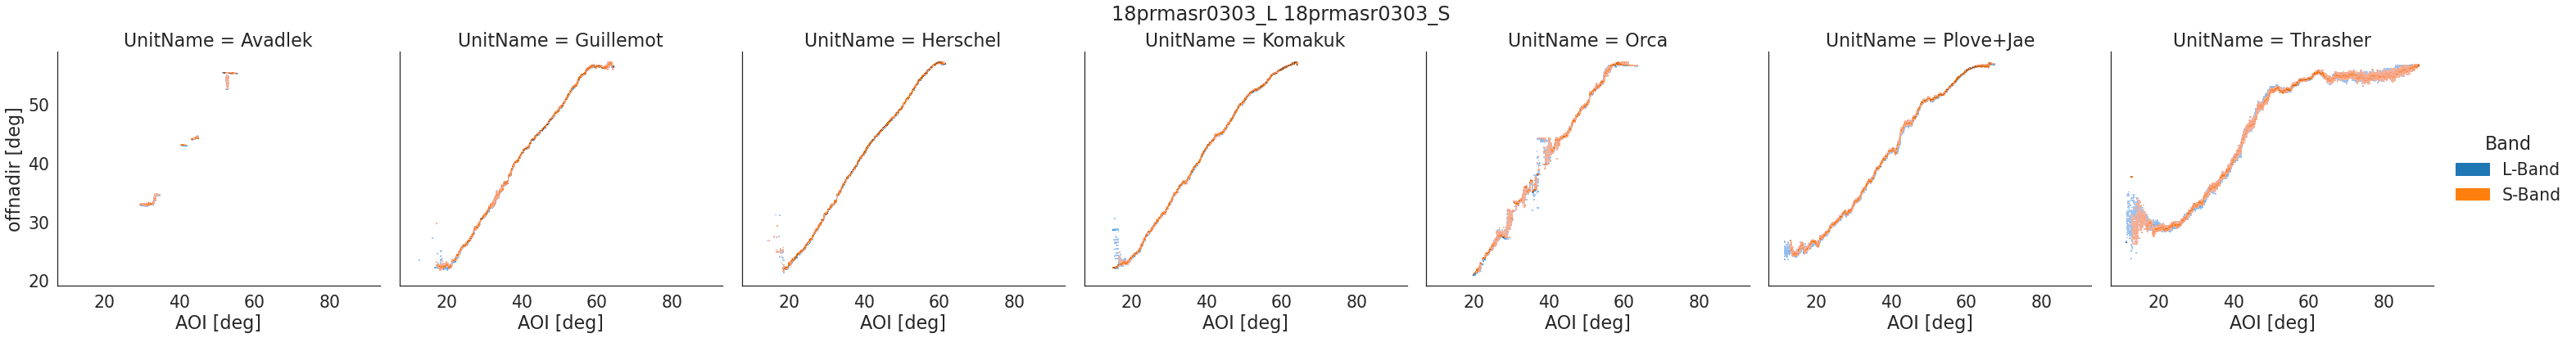

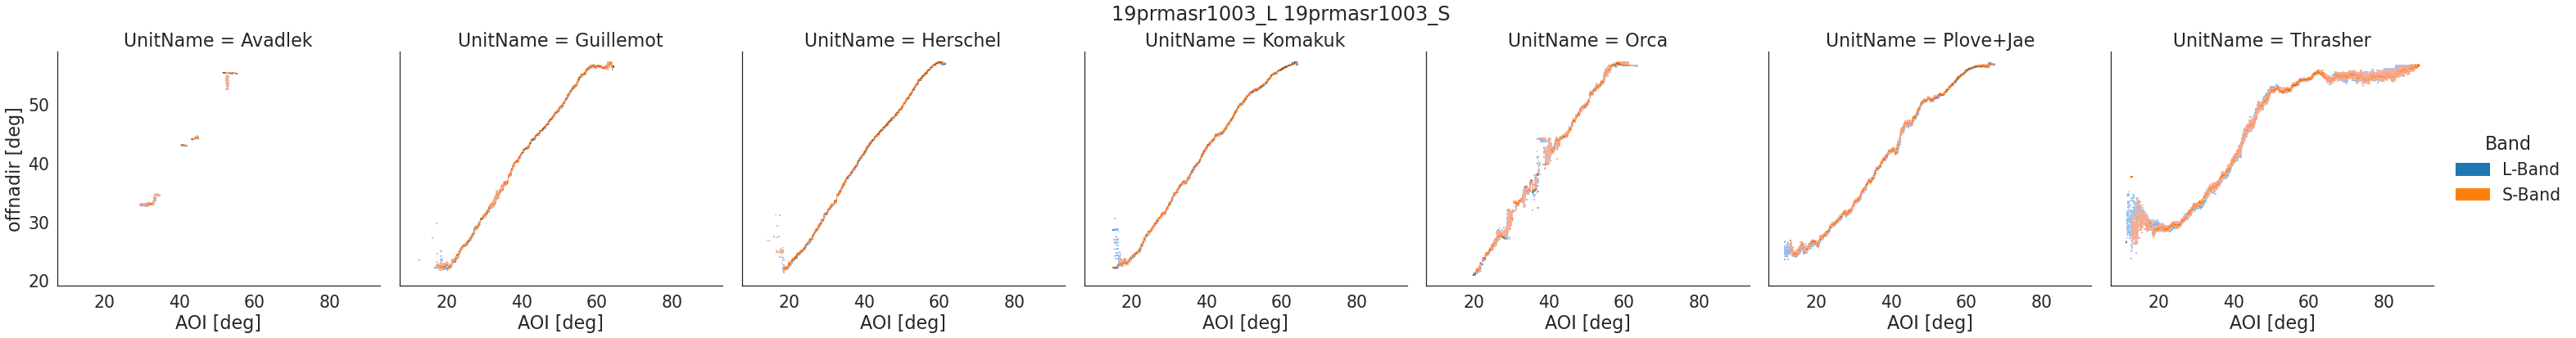

In [28]:
process(ID_Pass=1, x_hist="aoi")

#############
L 2
#############
../data/processed/ecological_masks/18prmasr0304_L.nc ../data/processed/ecological_masks/19prmasr1004_L.nc
../data/processed/ecological_masks/18prmasr0304_S.nc ../data/processed/ecological_masks/19prmasr1004_S.nc
#############
Avadlek
Guillemot
Herschel
Komakuk
Orca
Plove+Jae
Thrasher
entropy
Save Figure 18prmasr0304_L 18prmasr0304_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1004_L 19prmasr1004_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


anisotropy
Save Figure 18prmasr0304_L 18prmasr0304_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1004_L 19prmasr1004_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


alpha
Save Figure 18prmasr0304_L 18prmasr0304_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1004_L 19prmasr1004_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


p_hhvv
Save Figure 18prmasr0304_L 18prmasr0304_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1004_L 19prmasr1004_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


ph_diff_hhvv
Save Figure 18prmasr0304_L 18prmasr0304_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1004_L 19prmasr1004_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


aoi
offnadir
Save Figure 18prmasr0304_L 18prmasr0304_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


Save Figure 19prmasr1004_L 19prmasr1004_S


/data/largeHome/mans_is/.conda/envs/mans_is/envs/py3_mkl/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


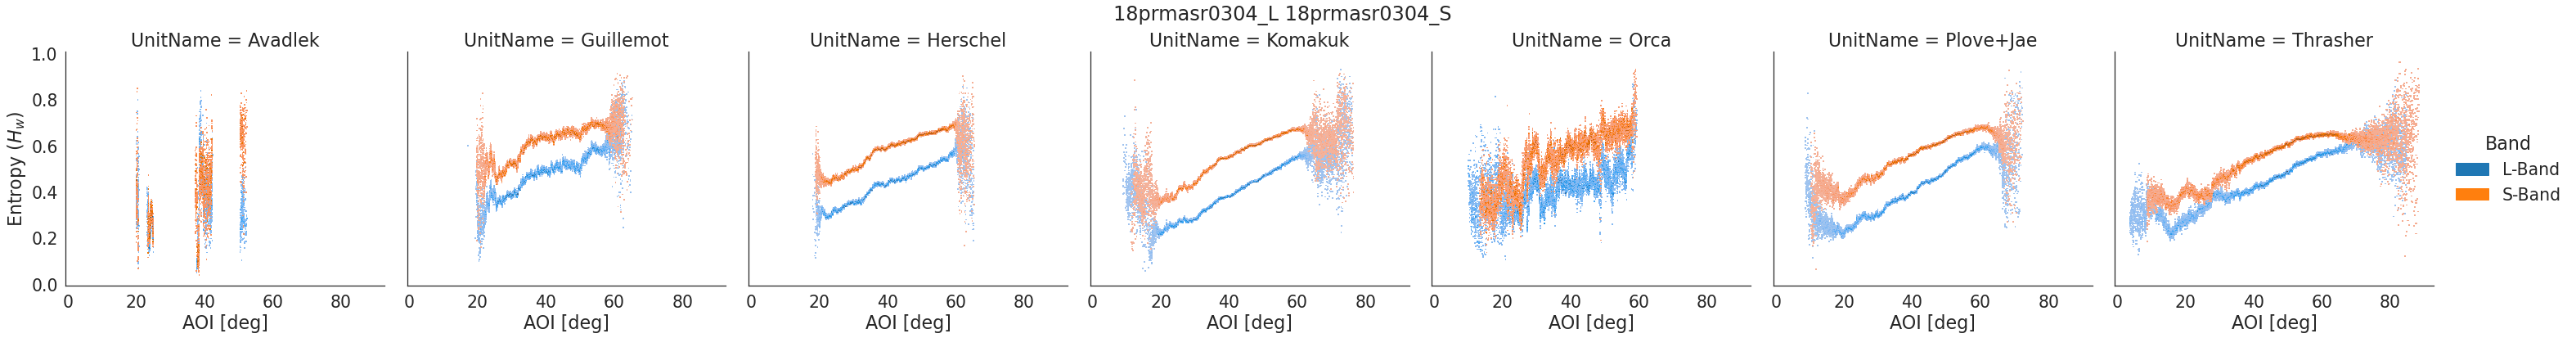

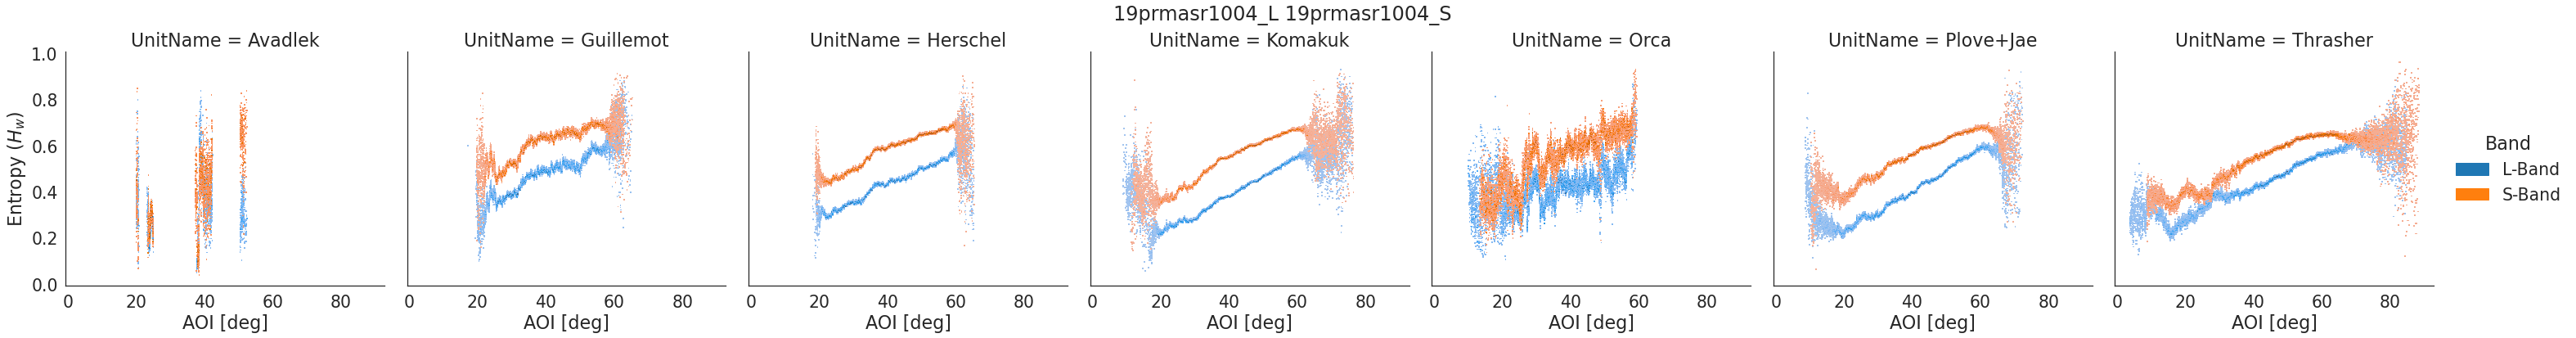

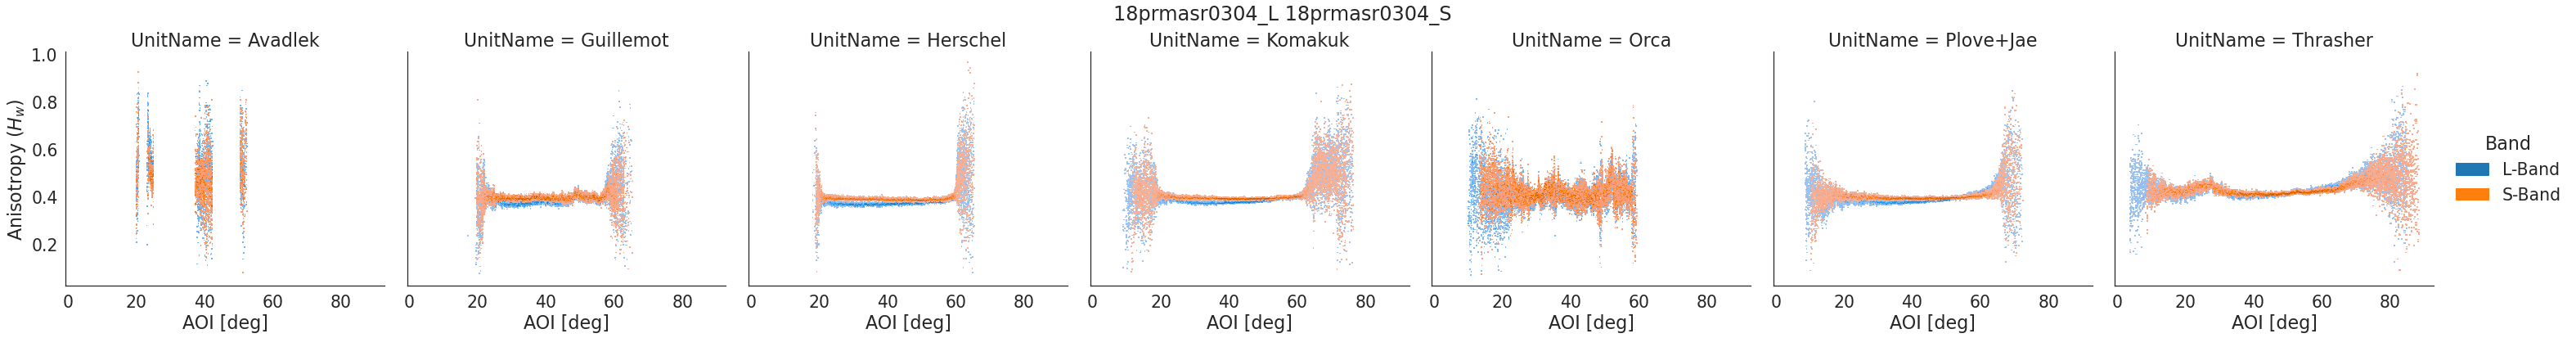

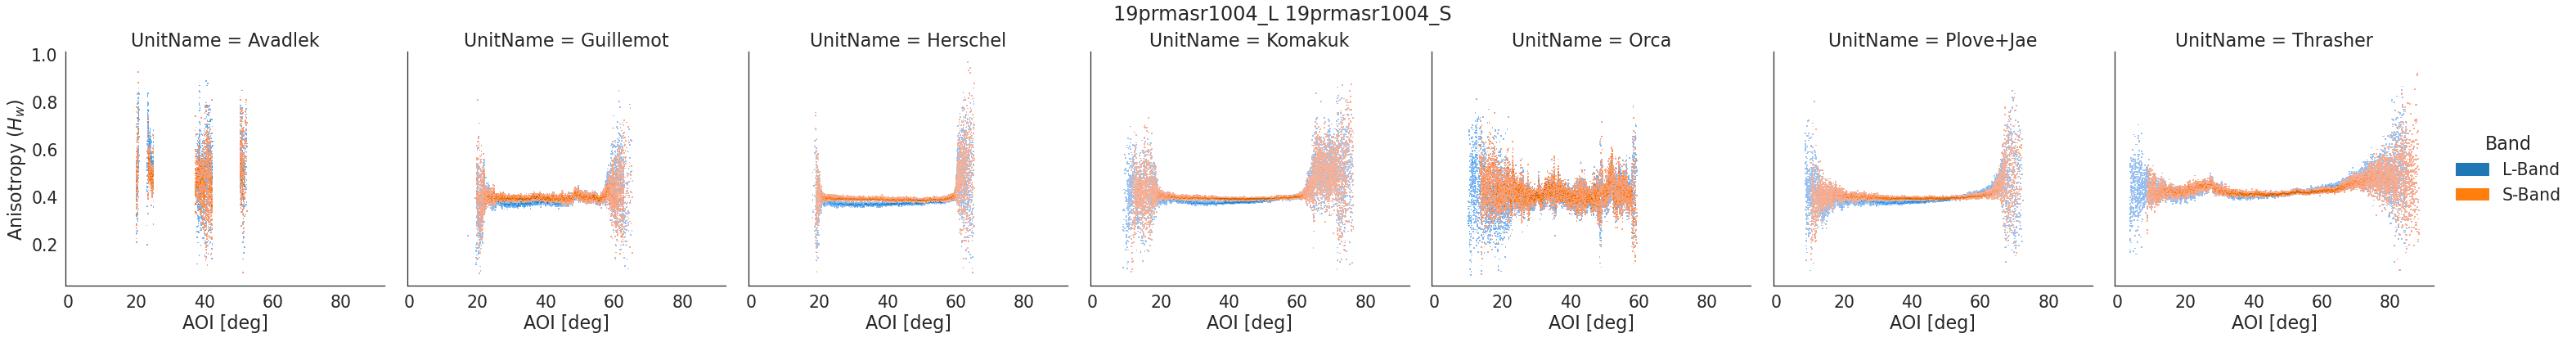

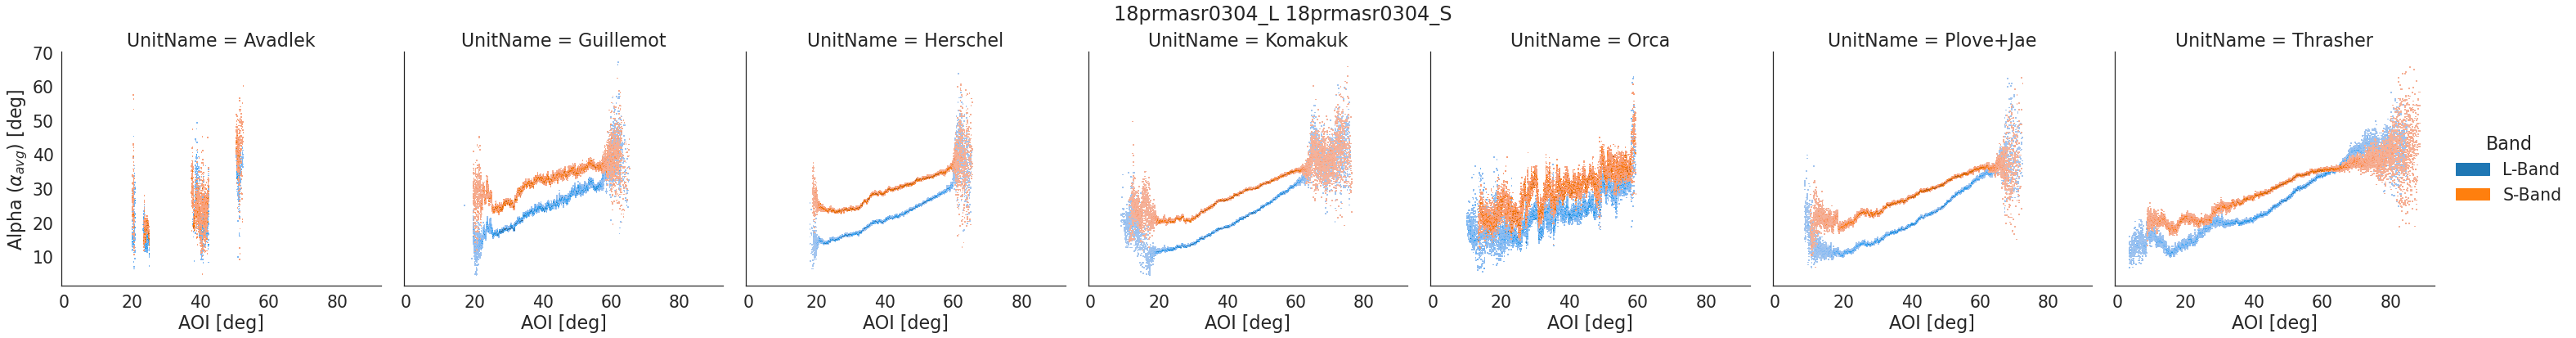

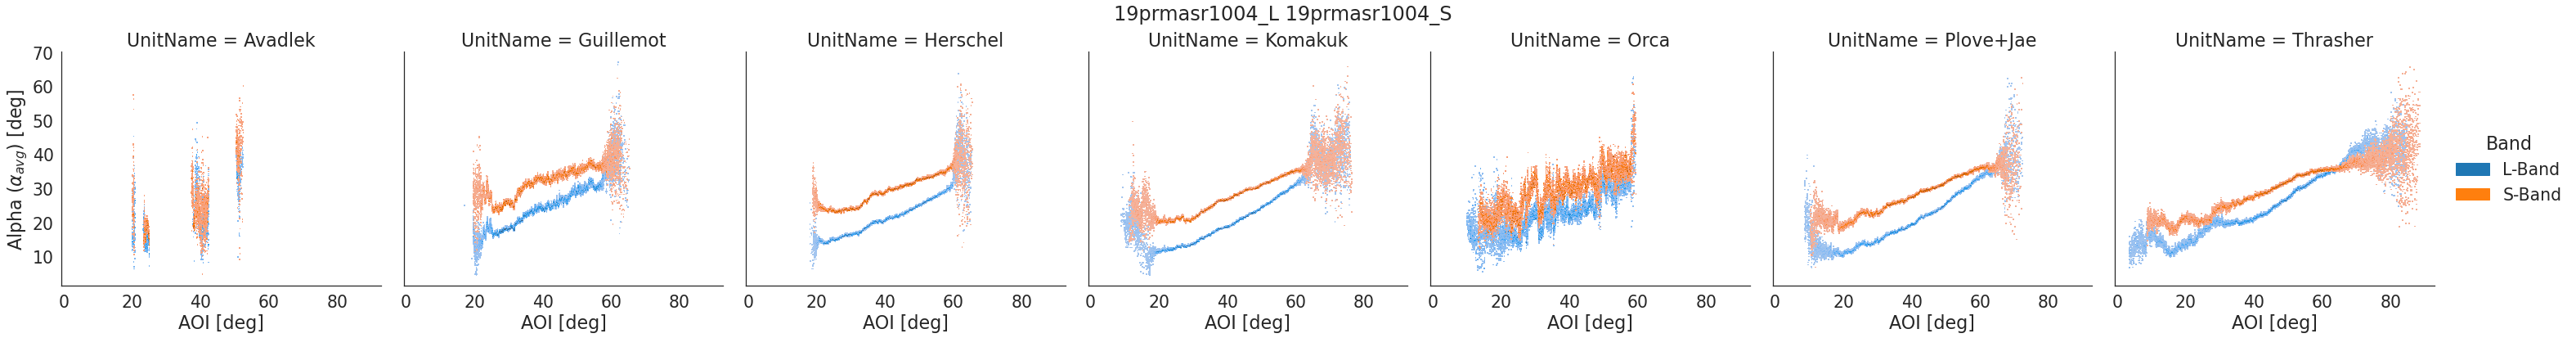

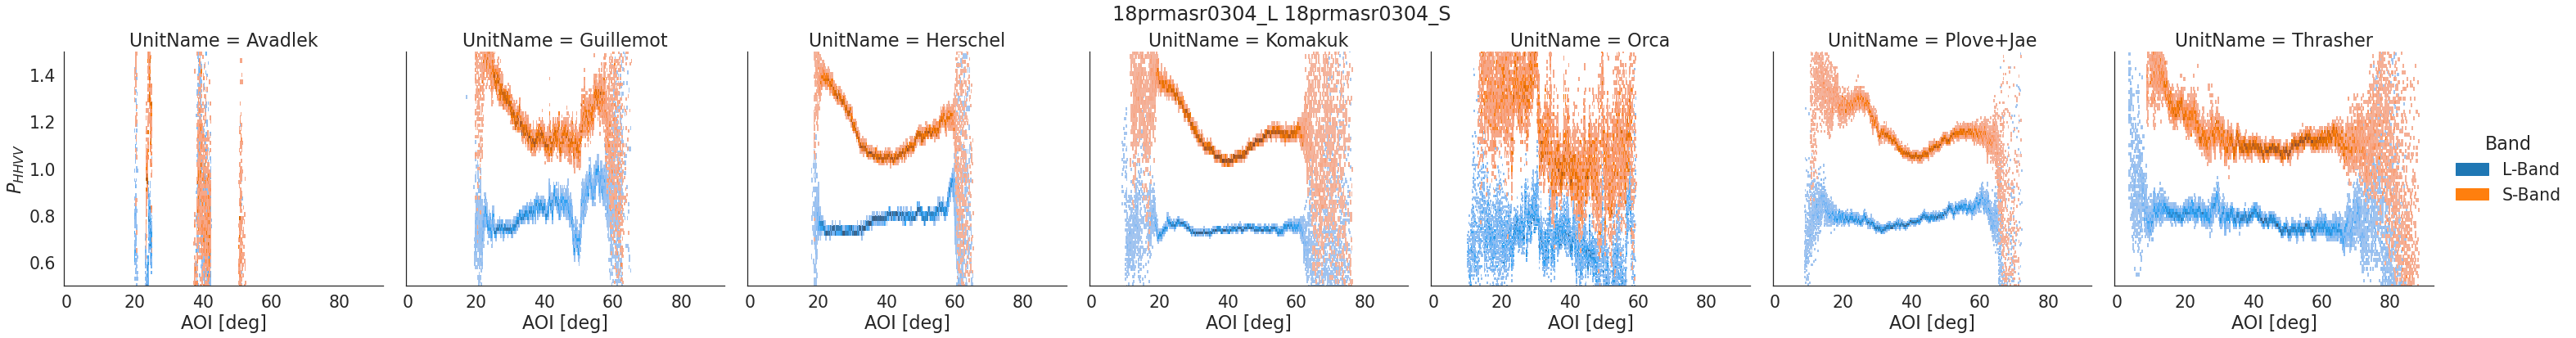

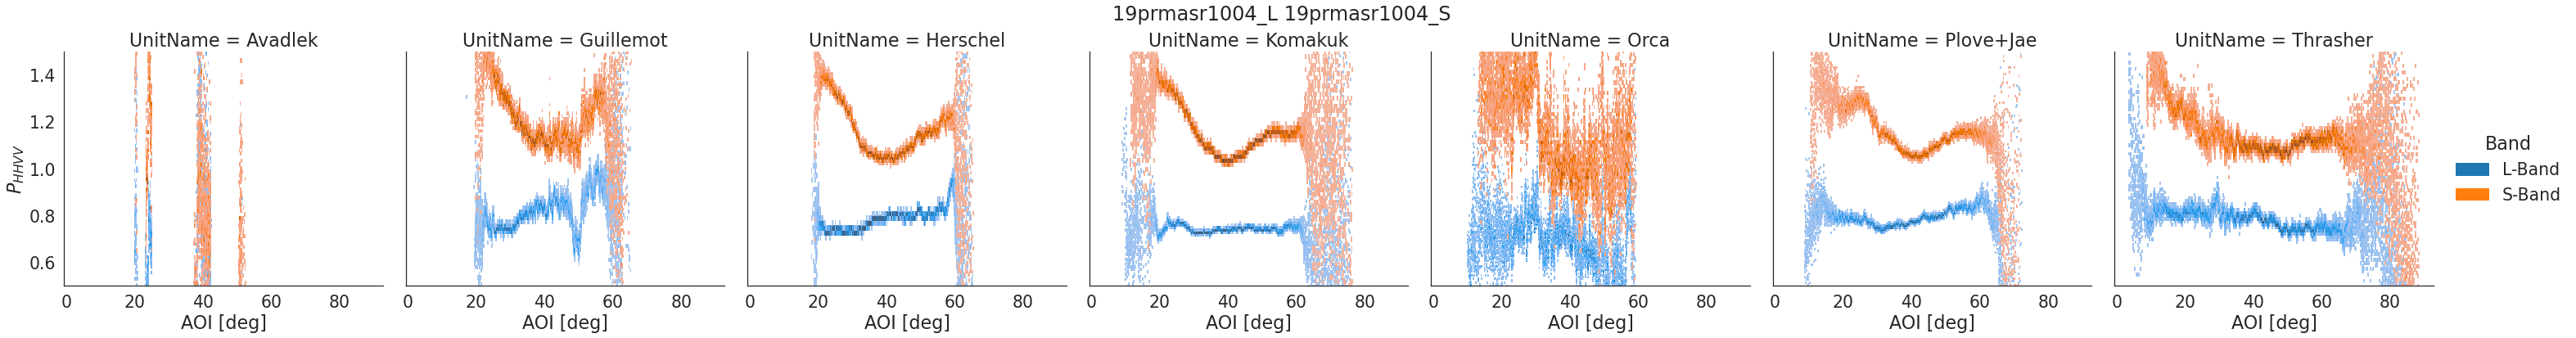

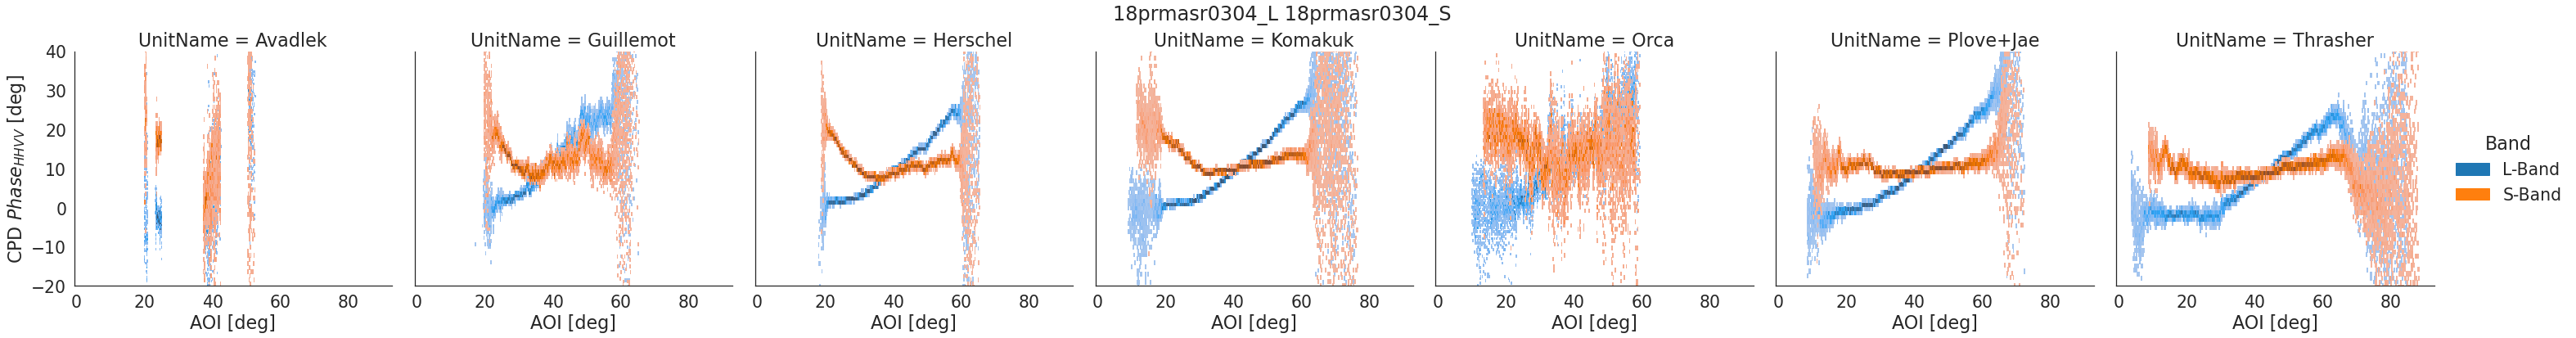

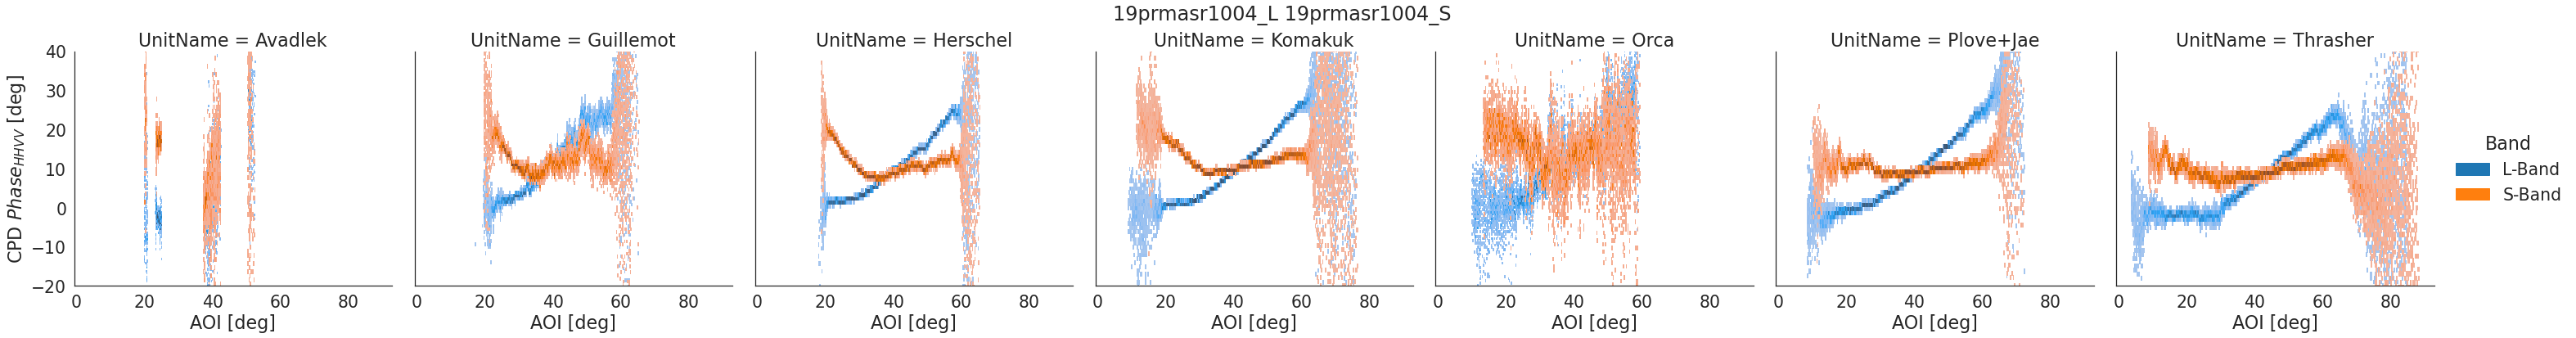

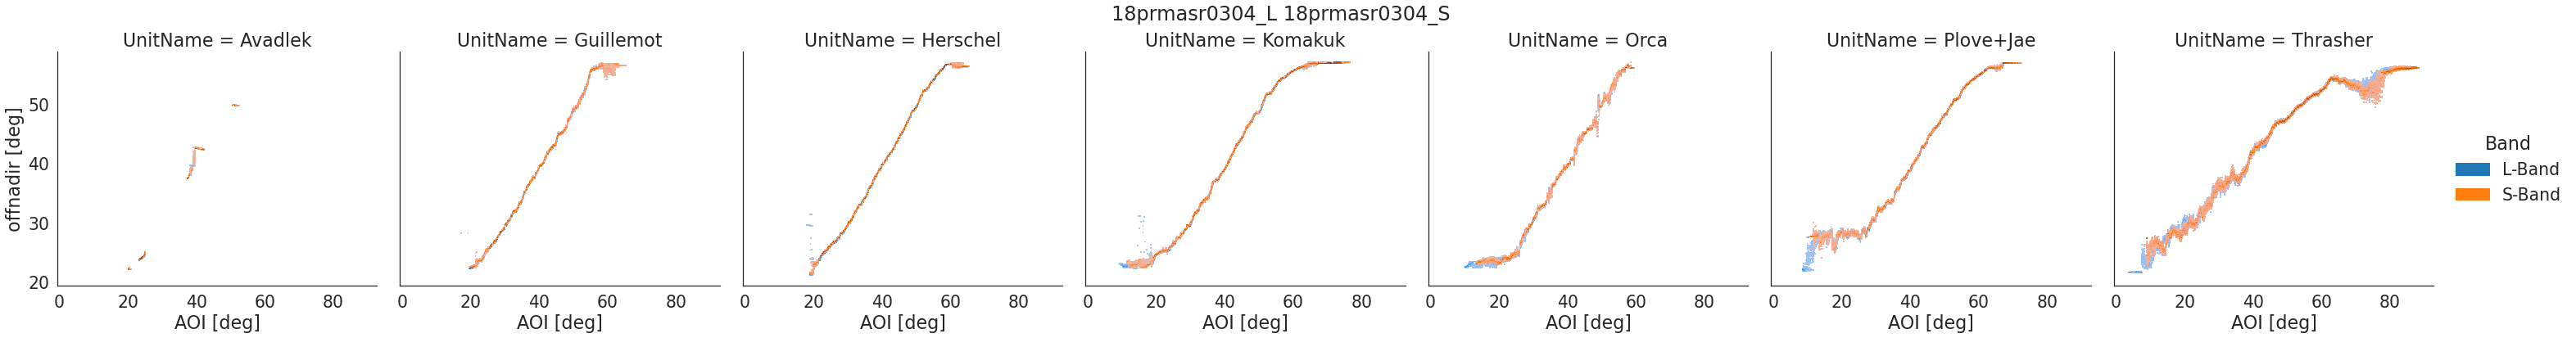

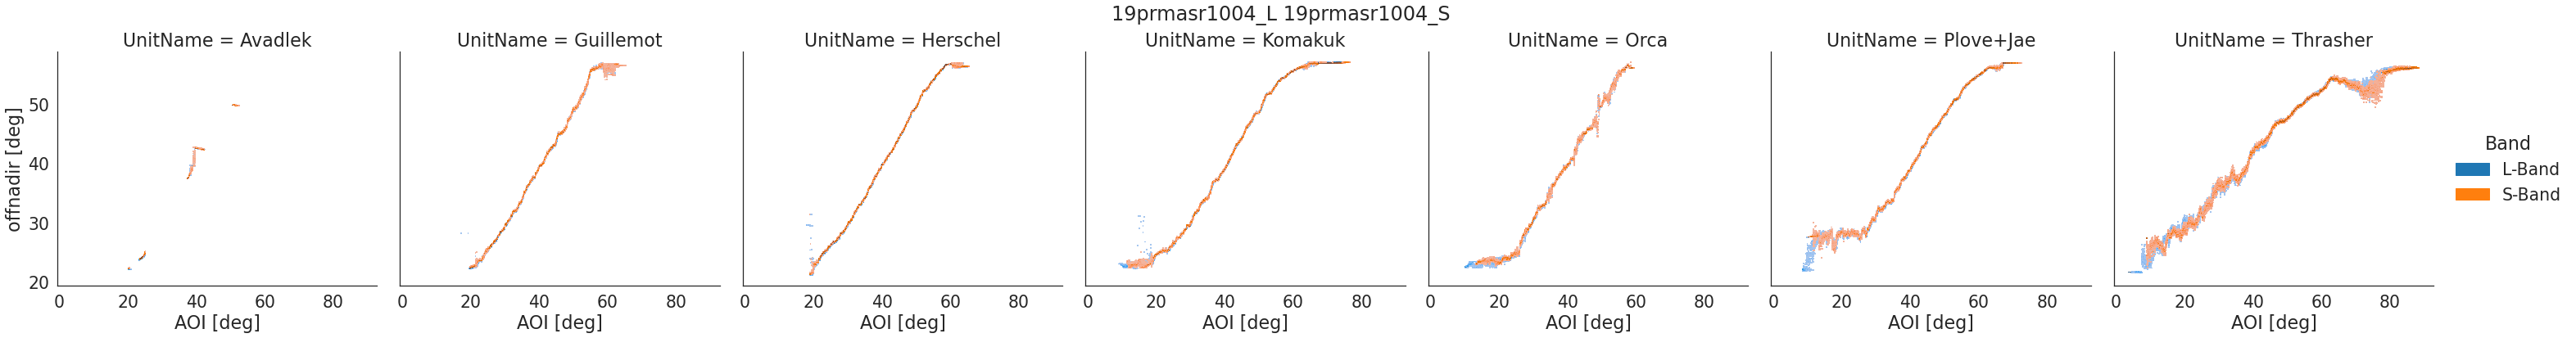

In [29]:
process(ID_Pass=2, x_hist="aoi")

In [ ]:
if __name__ == '__main__':
    import argparse

    parser = argparse.ArgumentParser(description='Create a ArcHydro schema')
    parser.add_argument('--band', metavar='str ["L", "S", "X", "P", "C"]', required=True,
                        help='band of F-SAR')
    parser.add_argument('--pass_id', metavar='N', type=int,  required=True,
                        help='pass id of the flight PS 05')
    
    parser.add_argument('--x_hist', metavar='str', required=True,
                        help='band of F-SAR')
    


    args = parser.parse_args()
    # main(workspace=args.workspace, schema=args.schema, dem=args.dem)
    colors_hex = ["#4DB65B", "#425DAA", "#F1EB58", "#A4AA56", "#49B0AD", "#A95052", "#74C044"]
    color_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']

    ecological_colors = {}
    for name, color_hex in zip(color_names, colors_hex):
        ecological_colors[name] = matplotlib.colors.to_rgb(color_hex)

    print(ecological_colors)
    unit_masks = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove_+Jae', 'Thrasher']
    unit_names = ['Avadlek', 'Guillemot', 'Herschel', 'Komakuk', 'Orca', 'Plove+Jae', 'Thrasher']
    
    process(band=args.band, 
            ID_Pass=args.pass_id, x_hist=args.x_hist,)